# Application Train EDA
1. About Dataset,
2. Data Cleaning,
3. Exploratory Data Analysis,
4. Statistical Inference,

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import gc
import math
from phik import resources
from scipy.stats import norm
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from statsmodels.stats.proportion import proportion_confint
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from pandas.api.types import CategoricalDtype
from textwrap import wrap
from functions import (
    show_head_and_info,
    missing_value_summary,
    fill_missing_values,
    iqr_outliers,
    phik_correlations_with_pval,
    remove_outliers_by_std,
    convert_days_to_months,
    convert_days_to_years,
    print_value_counts_by_target_pct,
    plot_numeric_features,
    plot_numeric_few_values_features,
    plot_categorical_features,
)
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_colwidth", None)

## 1. About Dataset

In [2]:
application_train_df = pd.read_csv("application_train.csv")

application_train_df.columns = (
    application_train_df.columns.str.strip().str.lower().str.replace(" ", "_")
)
show_head_and_info(application_train_df)

Data


,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, sk_id_curr to amt_req_credit_bureau_year
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


There is 307 511 obeservation and 122 features: 16 categorical and 106 numeric.

## 2. Data Cleaning

### 2.1. Missing values

In [3]:
missing_value_summary(application_train_df)

,Missing Count,Missing %
commonarea_medi,214865,69.87
commonarea_avg,214865,69.87
commonarea_mode,214865,69.87
nonlivingapartments_medi,213514,69.43
nonlivingapartments_mode,213514,69.43
nonlivingapartments_avg,213514,69.43
fondkapremont_mode,210295,68.39
livingapartments_mode,210199,68.35
livingapartments_medi,210199,68.35
livingapartments_avg,210199,68.35


For EDA part we going to handle missing values this way:
* Removing features that have more than 60 % missing values, because filling this missing values can create noise.
* For numeric features we use Simple Imputer to fill with median.
* For categorical features it will be filled with mode.

In [4]:
application_train_df = fill_missing_values(application_train_df)

missing_value_summary(application_train_df)

,Missing Count,Missing %


### 2.2. Duplicated Rows

In [5]:
application_train_df.duplicated().sum()

0

There is no more missing values and duplicated rows.

## 3. Exploratory Data Analysis

### 3.1. Distribution of Target

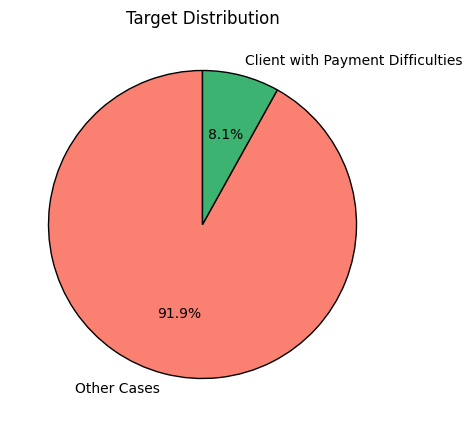

In [6]:
plt.figure(figsize=(7, 5))

target_counts = application_train_df["target"].value_counts().sort_index()

labels = ["Other Cases", "Client with Payment Difficulties"]
colors = ["salmon", "mediumseagreen"]

plt.pie(
    target_counts,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    wedgeprops={"edgecolor": "black"},
)
plt.title("Target Distribution")
plt.show()

We have imbalanced data with having only 8% of client with payment difficulties.

### 3.2. Numeric Features

#### 3.2.1. Features

In [7]:
application_numeric_features = (
    application_train_df.select_dtypes(include="number")
    .drop(columns=["target", "sk_id_curr"], errors="ignore")
    .columns
)

In [8]:
application_train_df[application_numeric_features].describe().round(2)

,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,cnt_fam_members,region_rating_client,region_rating_client_w_city,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,totalarea_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
count,307511.00,3.075110e+05,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.0,307511.00,307511.0,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.0,307511.00,307511.0,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00
mean,0.42,1.687979e+05,599026.00,27108.49,538316.29,0.02,-16037.00,63815.05,-4986.12,-2994.20,10.04,1.0,0.82,0.2,1.00,0.28,0.06,2.15,2.05,2.03,12.06,0.02,0.05,0.04,0.08,0.23,0.18,0.50,0.51,0.52,0.10,0.08,0.98,0.75,0.03,0.04,0.14,0.20,0.22,0.06,0.08,0.09,0.00,0.01,0.10,0.08,0.98,0.76,0.03,0.03,0.14,0.19,0.21,0.05,0.09,0.09,0.00,0.01,0.10,0.08,0.98,0.76,0.03,0.04,0.14,0.20,0.22,0.06,0.08,0.09,0.00,0.01,0.09,1.42,0.14,1.40,0.10,-962.86,0.00,0.71,0.00,0.02,0.09,0.00,0.08,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.01,0.01,0.03,0.23,0.23,1.78
std,0.72,2.371231e+05,402490.78,14493.46,369288.98,0.01,4363.99,141275.77,3522.89,1509.45,7.12,0.0,0.38,0.4,0.04,0.45,0.23,0.91,0.51,0.50,3.27,0.12,0.22,0.20,0.27,0.42,0.38,0.14,0.19,0.17,0.08,0.05,0.04,0.07,0.04,0.10,0.07,0.11,0.09,0.05,0.05,0.08,0.03,0.05,0.08,0.05,0.05,0.06,0.04,0.10,0.07,0.11,0.09,0.05,0.06,0.08,0.03,0.05,0.08,0.05,0.04,0.06,0.04,0.10,0.07,0.11,0.09,0.05,0.05,0.08,0.03,0.05,0.08,2.40,0.45,2.38,0.36,826.81,0.01,0.45,0.01,0.12,0.28,0.01,0.27,0.06,0.0,0.06,0.0,0.06,0.

In [9]:
numeric_part_1 = [
    "cnt_children",
    "amt_income_total",
    "amt_credit",
    "amt_annuity",
    "amt_goods_price",
    "region_population_relative",
    "days_birth",
    "days_employed",
    "days_registration",
    "days_id_publish",
    "days_last_phone_change",
    "cnt_fam_members",
    "hour_appr_process_start",
]
numeric_part_2 = [
    "ext_source_1",
    "ext_source_2",
    "ext_source_3",
    "days_last_phone_change",
    "obs_30_cnt_social_circle",
    "obs_60_cnt_social_circle",
    "totalarea_mode",
    "basementarea_avg",
    "basementarea_mode",
    "basementarea_medi",
    "landarea_avg",
    "landarea_mode",
]
numeric_part_3 = [
    "landarea_medi",
    "livingarea_avg",
    "livingarea_mode",
    "livingarea_medi",
    "nonlivingarea_avg",
    "nonlivingarea_mode",
    "nonlivingarea_medi",
    "apartments_avg",
    "apartments_mode",
    "apartments_medi",
    "elevators_avg",
    "elevators_mode",
]
numeric_part_4 = [
    "elevators_medi",
    "entrances_avg",
    "entrances_mode",
    "entrances_medi",
    "floorsmax_avg",
    "floorsmax_mode",
    "floorsmax_medi",
    "years_beginexpluatation_avg",
    "years_beginexpluatation_mode",
    "years_beginexpluatation_medi",
    "amt_req_credit_bureau_mon",
    "amt_req_credit_bureau_year",
]

numeric_few_part_1 = [
    "flag_mobil",
    "flag_emp_phone",
    "flag_work_phone",
    "flag_cont_mobile",
    "flag_phone",
    "flag_email",
    "def_30_cnt_social_circle",
    "def_60_cnt_social_circle",
    "amt_req_credit_bureau_qrt",
    "amt_req_credit_bureau_day",
    "amt_req_credit_bureau_hour",
    "amt_req_credit_bureau_week",
]
numeric_few_part_2 = [
    "region_rating_client",
    "region_rating_client_w_city",
    "reg_region_not_live_region",
    "reg_region_not_work_region",
    "live_region_not_work_region",
    "reg_city_not_live_city",
    "reg_city_not_work_city",
    "live_city_not_work_city",
]
numeric_few_part_3 = [
    "flag_document_2",
    "flag_document_3",
    "flag_document_4",
    "flag_document_5",
    "flag_document_6",
    "flag_document_7",
    "flag_document_8",
    "flag_document_9",
    "flag_document_10",
    "flag_document_11",
    "flag_document_12",
    "flag_document_13",
    "flag_document_14",
    "flag_document_15",
    "flag_document_16",
    "flag_document_17",
    "flag_document_18",
    "flag_document_19",
    "flag_document_20",
    "flag_document_21",
]

#### 3.2.2. Outlier

In [10]:
iqr_outliers(application_train_df, numeric_part_1)

Outliers detected in 'cnt_children': 4272
Outliers detected in 'amt_income_total': 14035
Outliers detected in 'amt_credit': 6562
Outliers detected in 'amt_annuity': 7504
Outliers detected in 'amt_goods_price': 14728
Outliers detected in 'region_population_relative': 8412
Outliers detected in 'days_birth': 0
Outliers detected in 'days_employed': 72217
Outliers detected in 'days_registration': 659
Outliers detected in 'days_id_publish': 0
Outliers detected in 'days_last_phone_change': 435
Outliers detected in 'cnt_fam_members': 4007
Outliers detected in 'hour_appr_process_start': 2257


* Most outliers: days_employed - 72 217, amt_goods_price - 14 728 and amt_income_total - 14 035.
* days_birth, days_id_publish have no outliers.

In [11]:
iqr_outliers(application_train_df, numeric_part_2)

Outliers detected in 'ext_source_1': 134131
Outliers detected in 'ext_source_2': 0
Outliers detected in 'ext_source_3': 4313
Outliers detected in 'days_last_phone_change': 435
Outliers detected in 'obs_30_cnt_social_circle': 19971
Outliers detected in 'obs_60_cnt_social_circle': 19564
Outliers detected in 'totalarea_mode': 141917
Outliers detected in 'basementarea_avg': 127483
Outliers detected in 'basementarea_mode': 127476
Outliers detected in 'basementarea_medi': 127481
Outliers detected in 'landarea_avg': 124811
Outliers detected in 'landarea_mode': 124827


* Most outliers: totalarea_mode - 141 917, ext_source_1 - 134 131.
* ext_source_2 have no outliers.

In [12]:
iqr_outliers(application_train_df, numeric_part_3)

Outliers detected in 'landarea_medi': 124819
Outliers detected in 'livingarea_avg': 153089
Outliers detected in 'livingarea_mode': 152942
Outliers detected in 'livingarea_medi': 153080
Outliers detected in 'nonlivingarea_avg': 137430
Outliers detected in 'nonlivingarea_mode': 137352
Outliers detected in 'nonlivingarea_medi': 137422
Outliers detected in 'apartments_avg': 150931
Outliers detected in 'apartments_mode': 143928
Outliers detected in 'apartments_medi': 151063
Outliers detected in 'elevators_avg': 57902
Outliers detected in 'elevators_mode': 54122


* Most outliers: livingarea_avg - 153 089, livingarea_medi - 153 080 and livingarea_mode - 152 942.
* elevators_mode - 54 122 and elevators_avg - 57 902.

In [13]:
iqr_outliers(application_train_df, numeric_part_4)

Outliers detected in 'elevators_medi': 56594
Outliers detected in 'entrances_avg': 118676
Outliers detected in 'entrances_mode': 116642
Outliers detected in 'entrances_medi': 117148
Outliers detected in 'floorsmax_avg': 92616
Outliers detected in 'floorsmax_mode': 88941
Outliers detected in 'floorsmax_medi': 90884
Outliers detected in 'years_beginexpluatation_avg': 142016
Outliers detected in 'years_beginexpluatation_mode': 141861
Outliers detected in 'years_beginexpluatation_medi': 142141
Outliers detected in 'amt_req_credit_bureau_mon': 43759
Outliers detected in 'amt_req_credit_bureau_year': 7233


* Most outliers: years_beginexpluatation_avg - 142 016, years_beginexpluatation_mode - 141 861 and years_beginexpluatation_medi - 142 141.
* Least: amt_req_credit_bureau_year - 7 233.

#### 3.2.3. Distribution

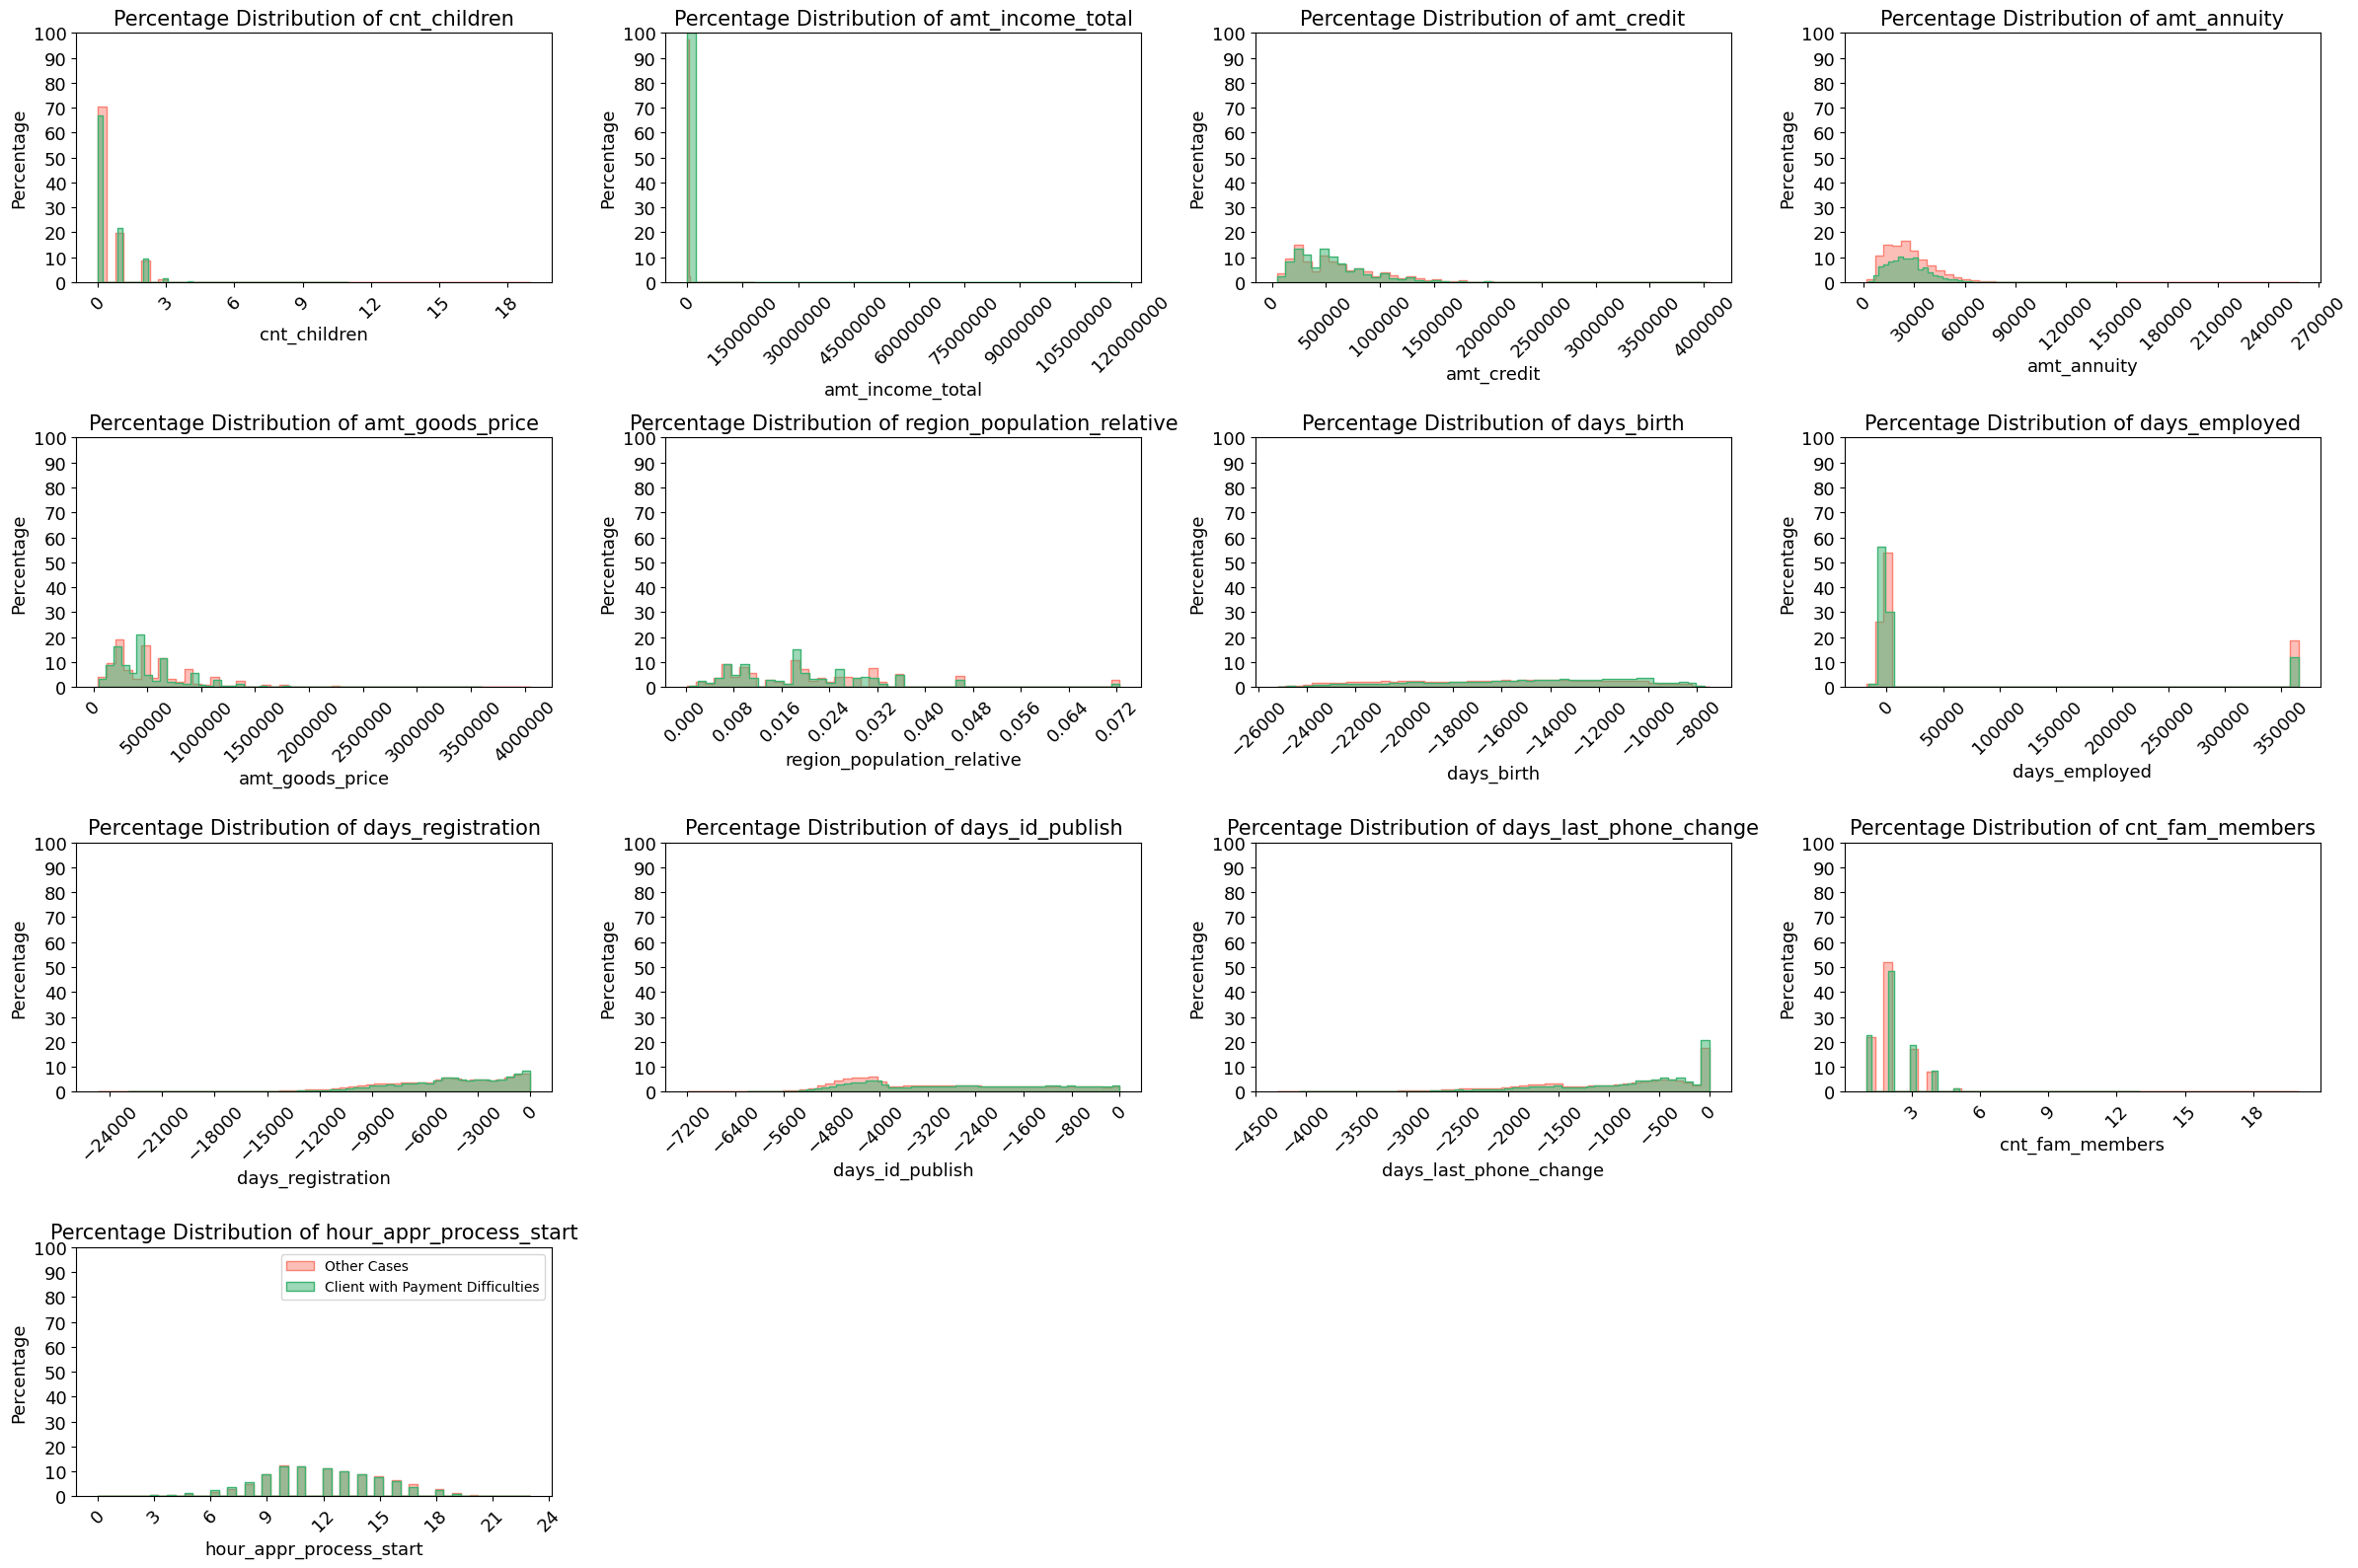

In [14]:
plot_numeric_features(application_train_df, numeric_part_1)

* cnt_children, cnt_fam_members: both distributions is skewed right, but clients with payment difficulties have slightly higher for more childre and larger families.
* amt_income_total: distribution for both groups is almost identical.
* amt_annuity, amt_credit, amt_goods_price: clients with payment difficulties show slightly higher densities in lower bins, but overall distributions are fairly similar.
* region_population_relative: very similar for both groups, no visible separation between the distributions.
* days_birth: slight difference, clients with payment difficulties skew a bit younger (less negative days).
* days_employed: large spike around 365 243 days (might be a placeholder or missing values) is more frequent in clients with payment difficulties.
* days_registration, days_id_publish: overlapping, with no major visual difference between the groups.
* hour_appr_process_start: very similar pattern, with a bell shape peaking during working hours (~10-14).

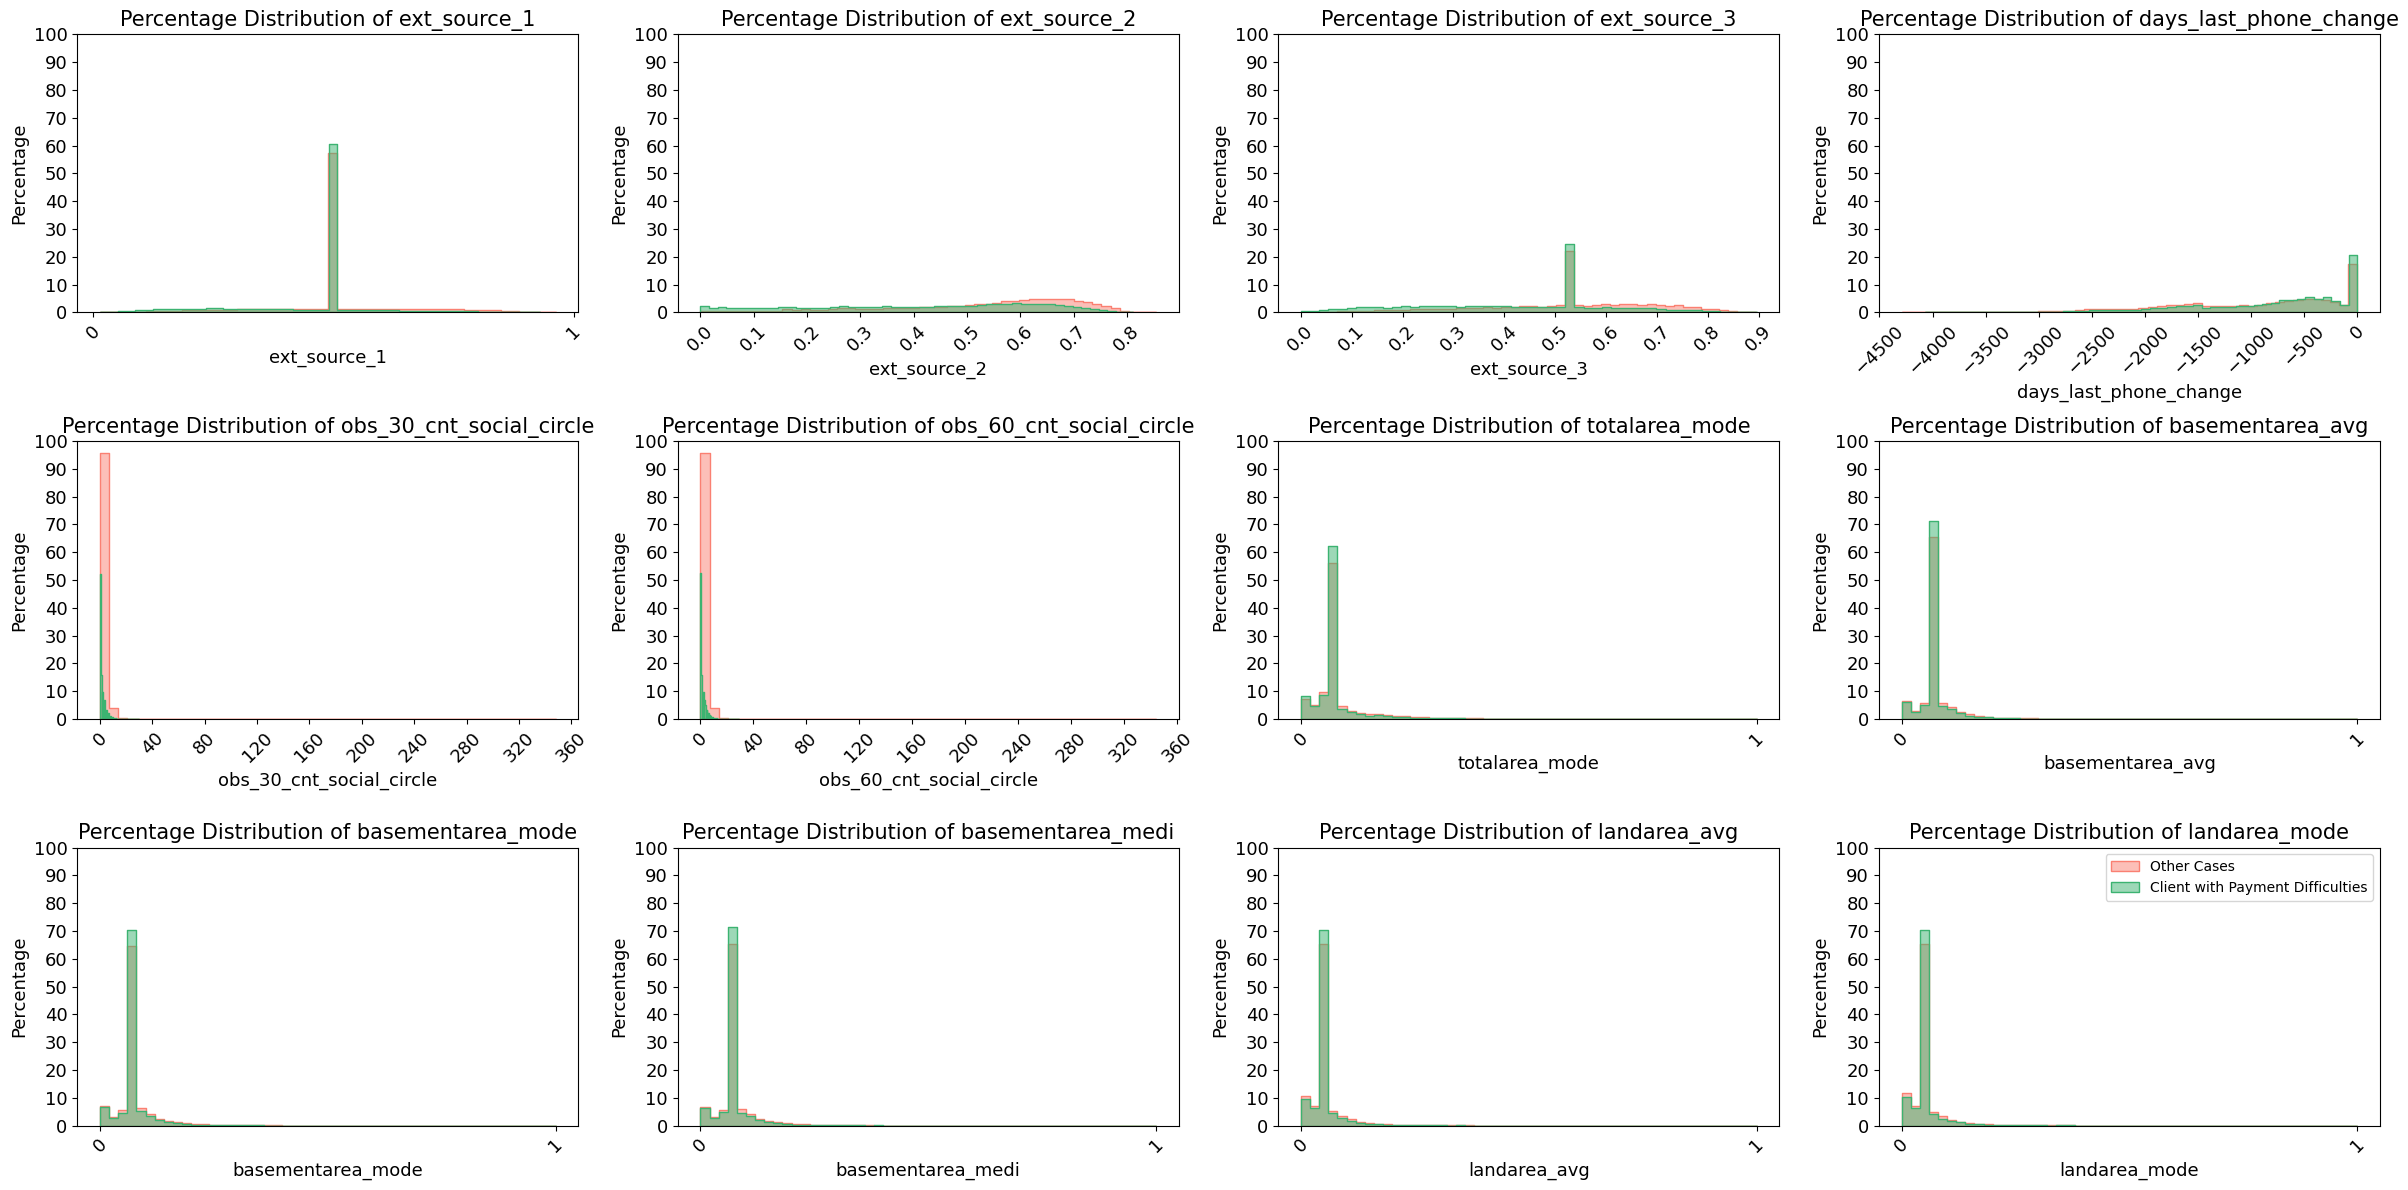

In [15]:
plot_numeric_features(application_train_df, numeric_part_2)

* ext_source_1, ext_source_2, ext_source_3: clients with lower values in these features (i.e., higher risk) are more likely to have payment difficulties.
* days_last_phone_change: clients with payment difficulties have slightly more recent phone changes.
* obs_30_cnt_social_circle, obs_60_cnt_social_circle: clients with payment difficulties show slightly fatter tails and higher values (more observed defaults in their social circle).
* totalarea_mode, basementarea and landarea features: clients with payment difficulties lean slightly more toward lower values.

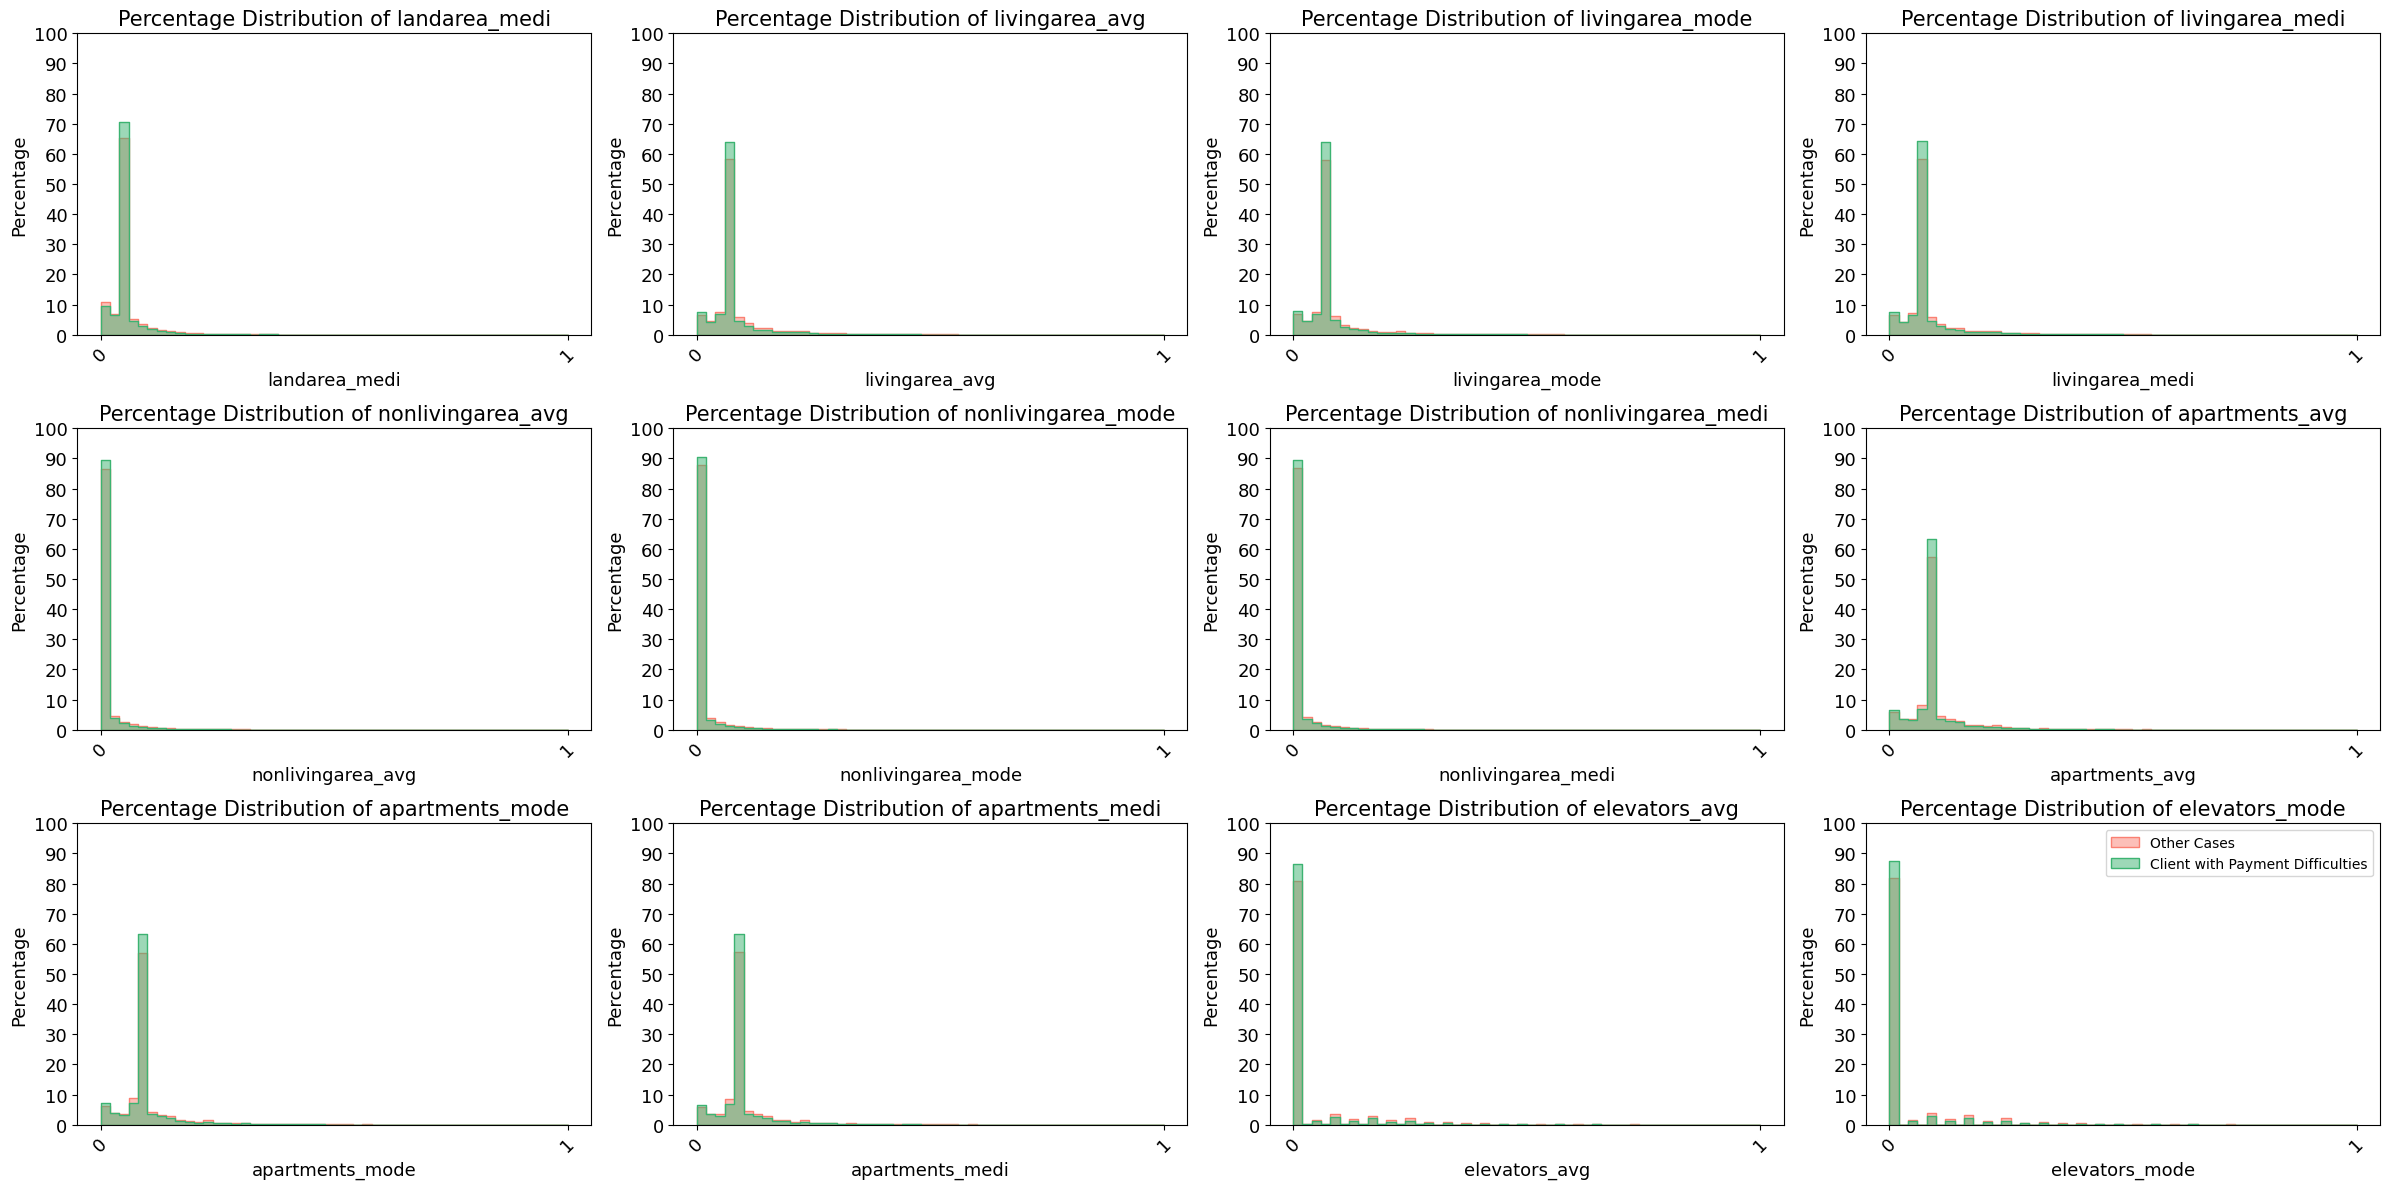

In [16]:
plot_numeric_features(application_train_df, numeric_part_3)

* landarea_medi: clients with payment difficulties lean slightly more toward lower values.
* livingarea_avg, livingarea_mode, livingarea_medi: clients with payment difficulties tend to have slightly smaller living areas.
* nonlivingarea_avg, nonlivingarea_mode, nonlivingarea_medi: clients with payment difficulties show a slight shift toward lower non-living area values.
* apartments_avg, apartments_mode, apartments_medi: clients with payment difficulties are slightly more concentrated in buildings with fewer apartment units.
* elevators_avg, elevators_mode: clients with payment difficulties are more likely to be in buildings with fewer or no elevators.

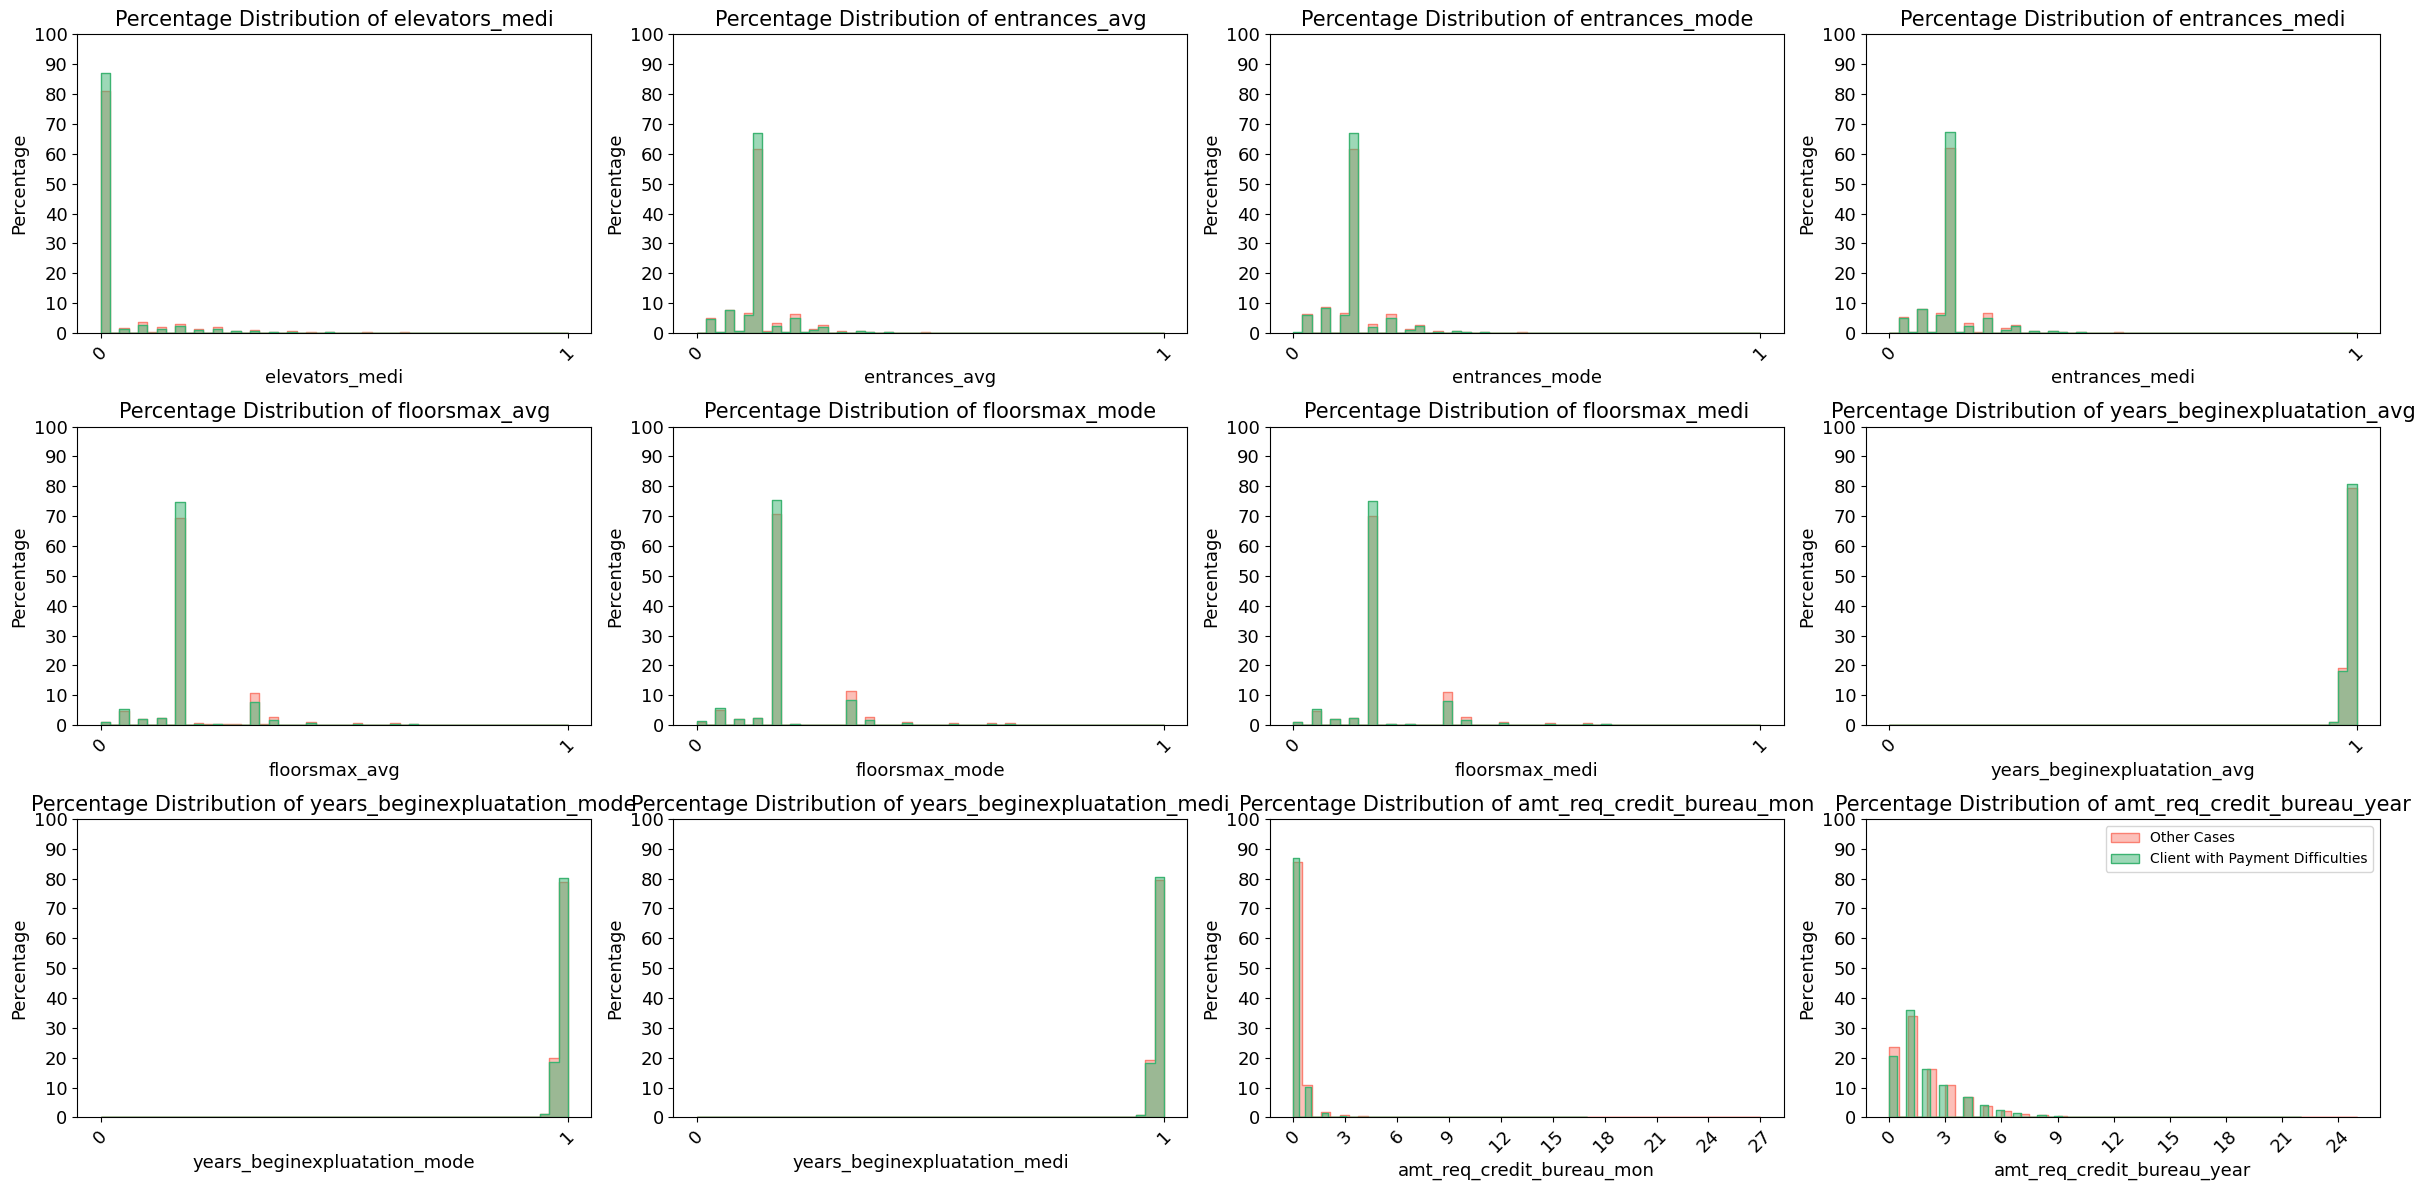

In [17]:
plot_numeric_features(application_train_df, numeric_part_4)

* elevators_medi: clients with payment difficulties are more concentrated in buildings with fewer or no elevators.
* entrances_avg, entrances_mode, entrances_medi: clients with payment difficulties tend to live in buildings with fewer entrances.
* floorsmax_avg, floorsmax_mode, floorsmax_medi: clients with payment difficulties more frequently reside in lower-rise buildings.
* years_beginexpluatation (all): clients with payment difficulties are slightly more associated with older buildings (i.e., earlier exploitation years).
* amt_req_credit_bureau_mon, amt_req_credit_bureau_year: clients with payment difficulties request credit more frequently—particularly visible in the annual request distribution.

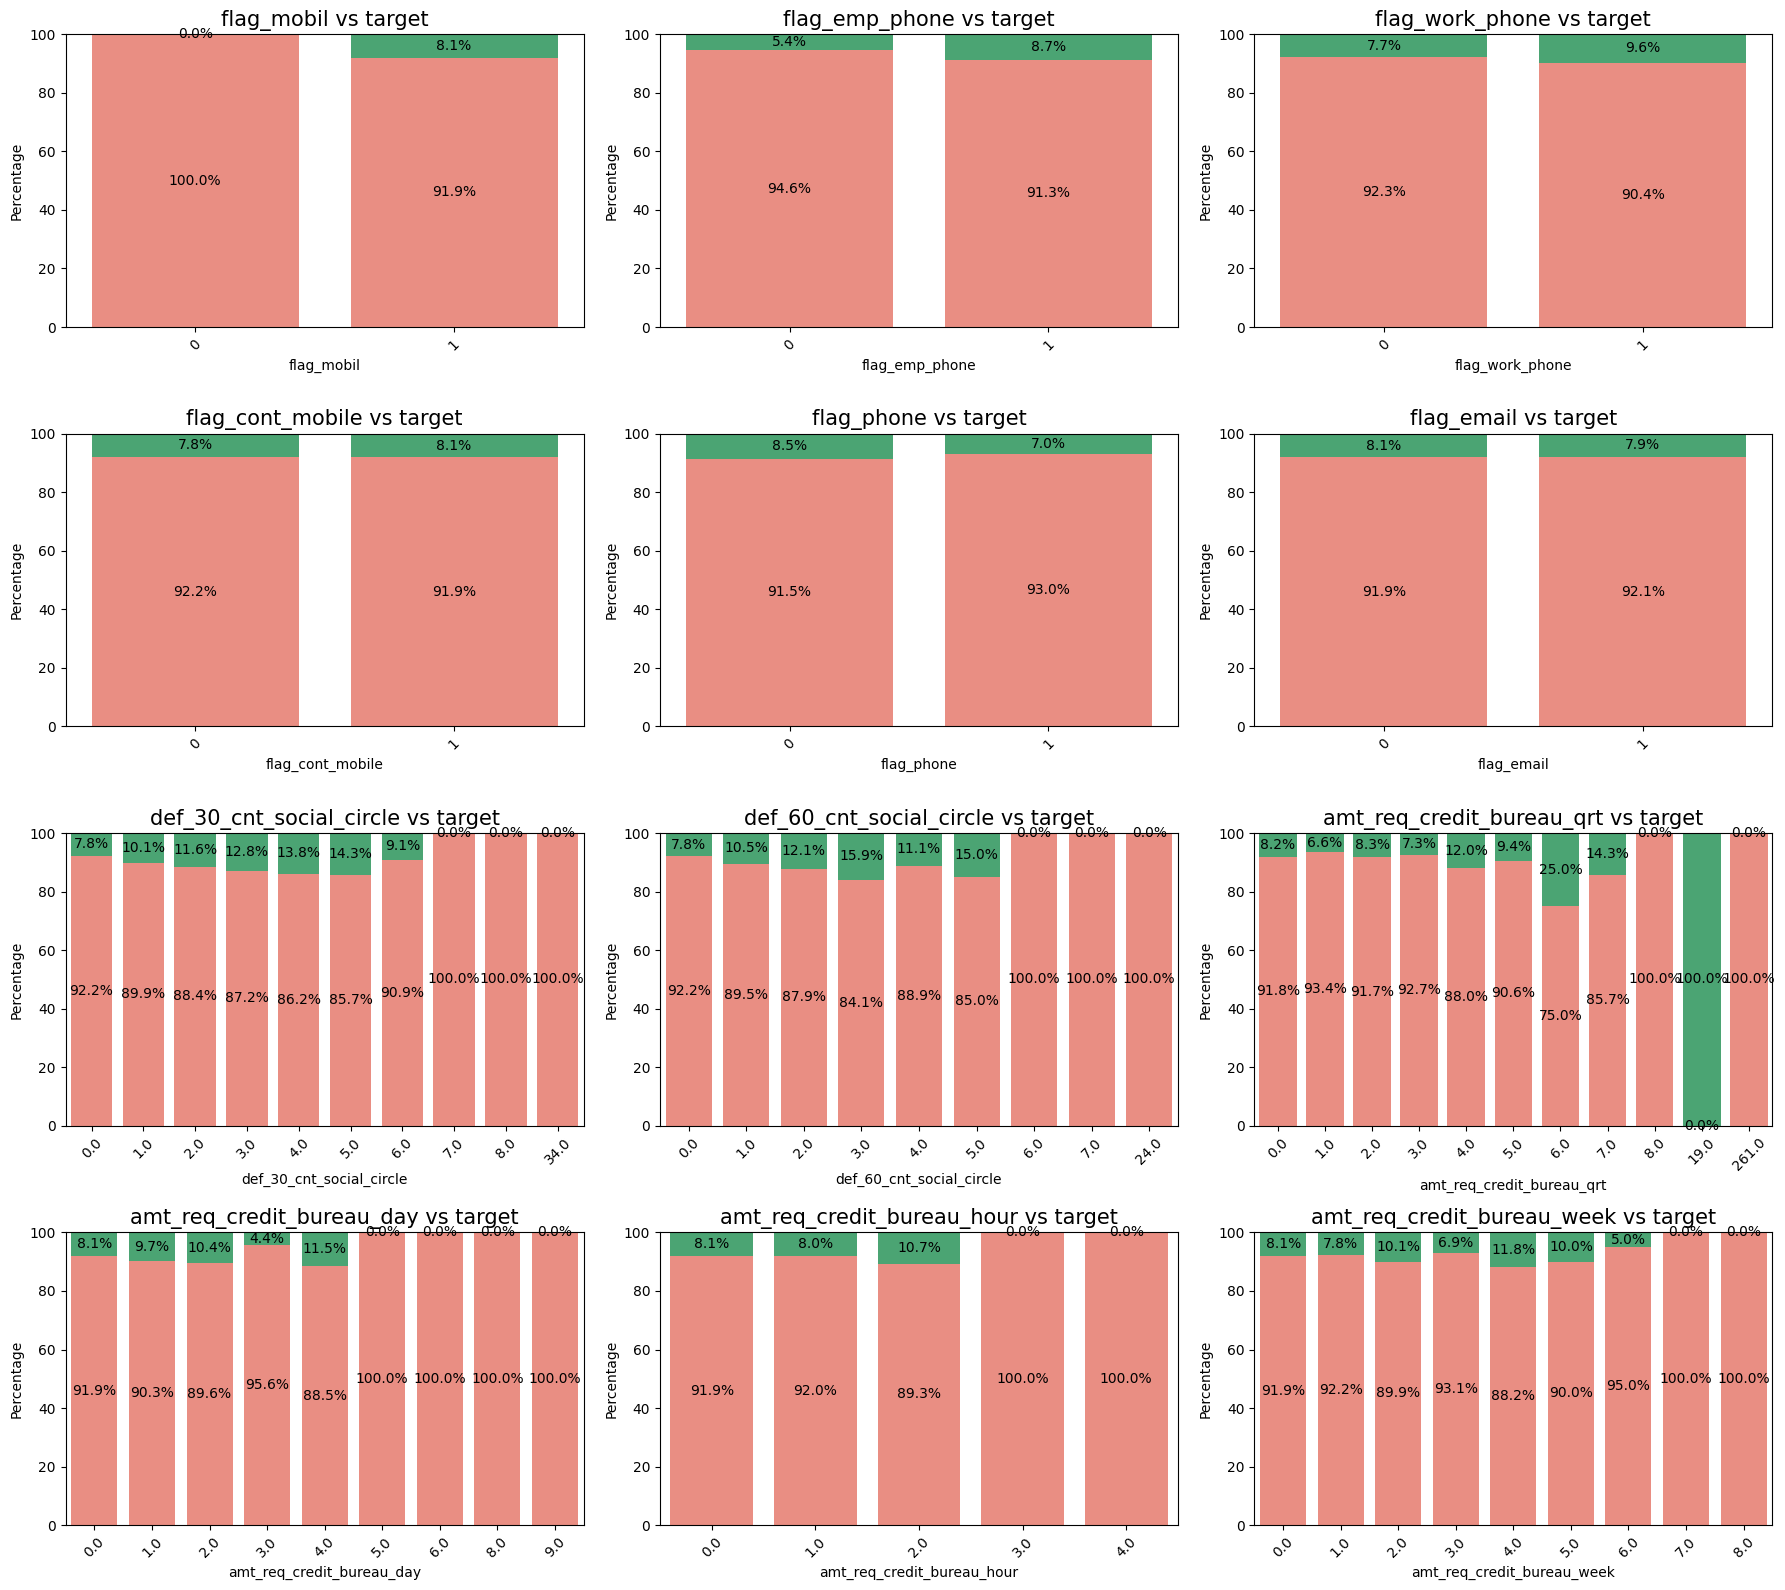

In [18]:
plot_numeric_few_values_features(application_train_df, numeric_few_part_1)

* flag_mobil, flag_cont_mobile, flag_phone, flag_email: no meaningful difference in default rates across categories—distributions are nearly identical.
* flag_emp_phone, flag_work_phone: clients with payment difficulties are slightly less likely to have employment or work phones registered.
* def_30_cnt_social_circle, def_60_cnt_social_circle: clients with payment difficulties are modestly more represented in higher default counts within their social circles.
* amt_req_credit_bureau_qrt, day, hour, week: higher frequencies of recent credit inquiries (especially quarterly and daily) correlate with a slightly increased likelihood of payment difficulties.

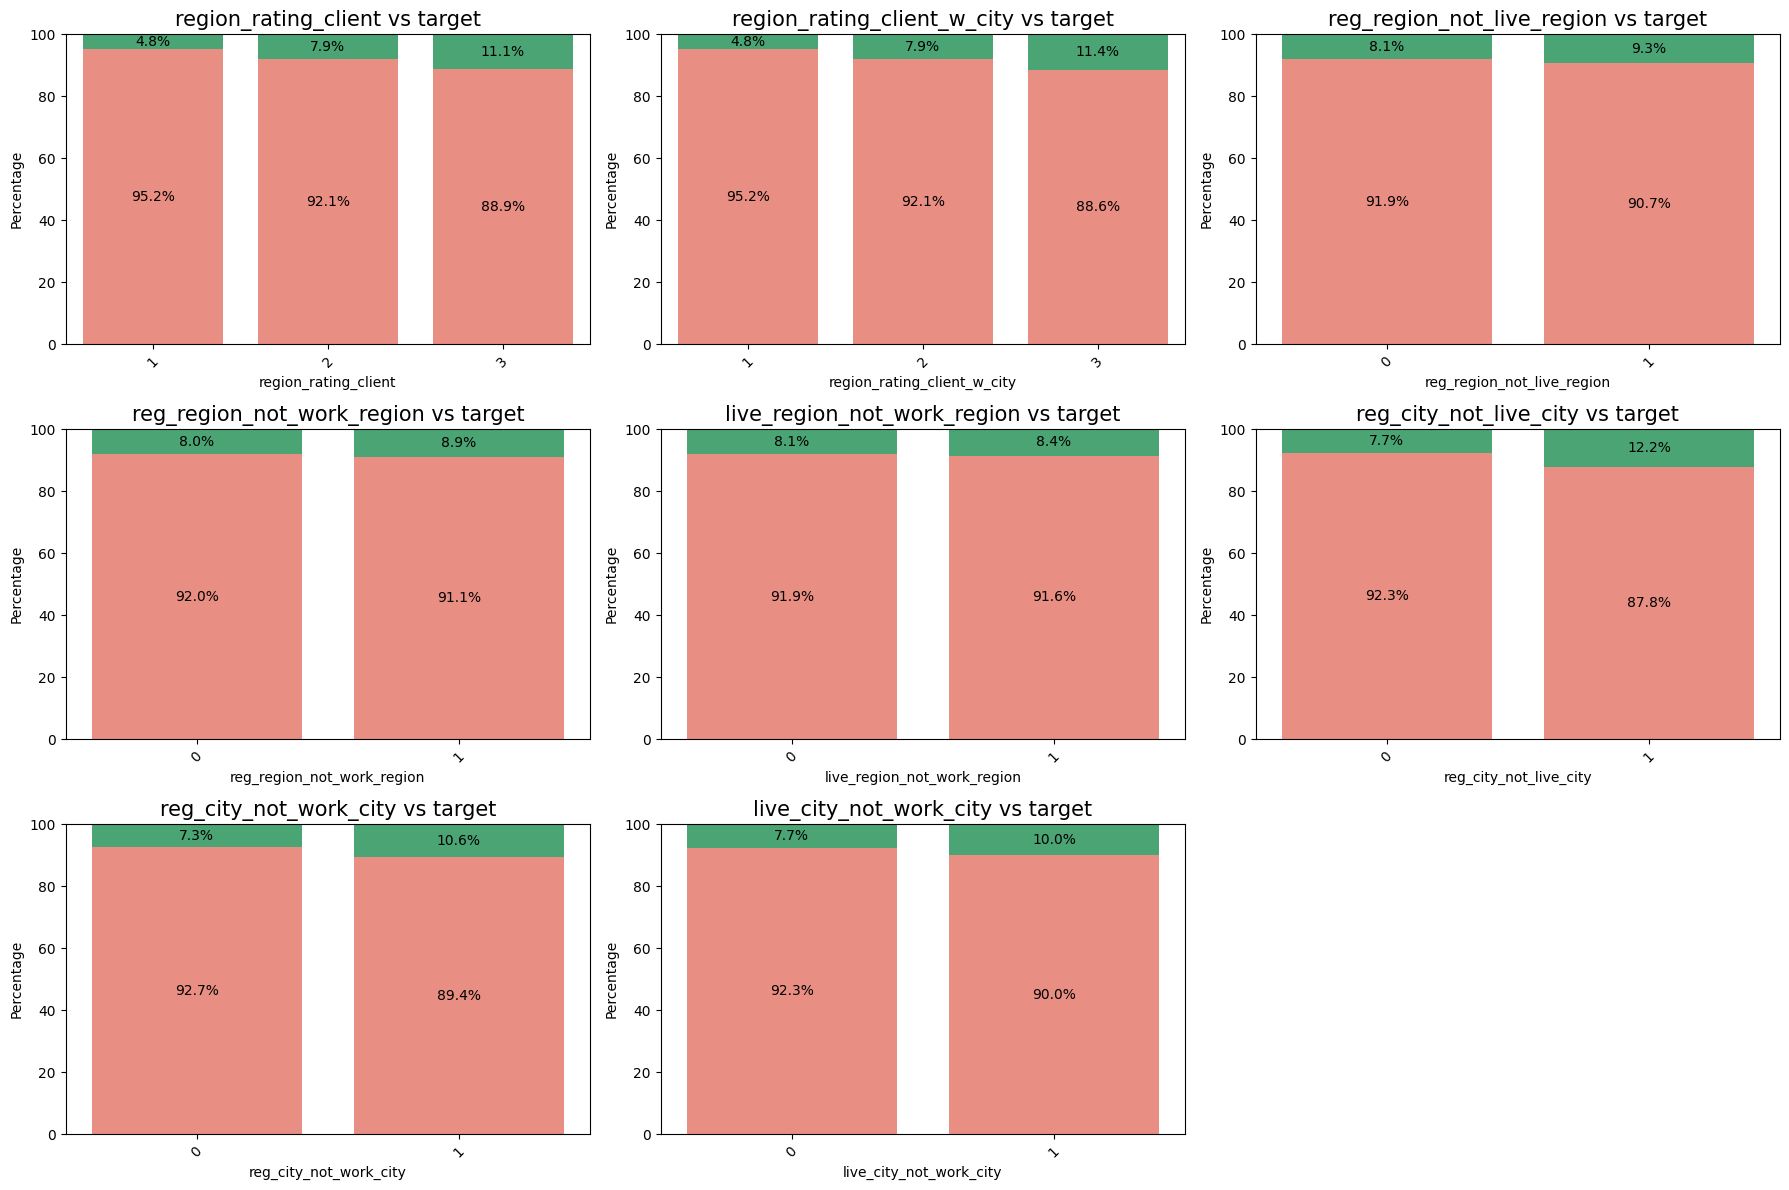

In [19]:
plot_numeric_few_values_features(application_train_df, numeric_few_part_2)

* region_rating_client and region_rating_client_w_city: Clients with higher region ratings (category 3 compared to 1 or 2) show a notably increased likelihood of being in the green target group. The proportion in this group more than doubles from rating 1 to rating 3.
* reg_city_not_live_city: A mismatch between a client's registration city and living city is strongly associated with a higher proportion in the green target group (e.g., 12.2% if mismatched vs. 7.7% if not).
* reg_city_not_work_city and live_city_not_work_city: Clients whose registration city or living city does not match their work city also have an increased likelihood of being in the green target group, though this effect is slightly less pronounced than the reg_city_not_live_city mismatch.
* reg_region_not_live_region: A mismatch between a client's registration region and living region correlates with a slightly higher proportion in the green target group.
* reg_region_not_work_region and live_region_not_work_region: Mismatches between registration/living region and work region show only a very slight to negligible increase in the proportion of clients in the green target group.

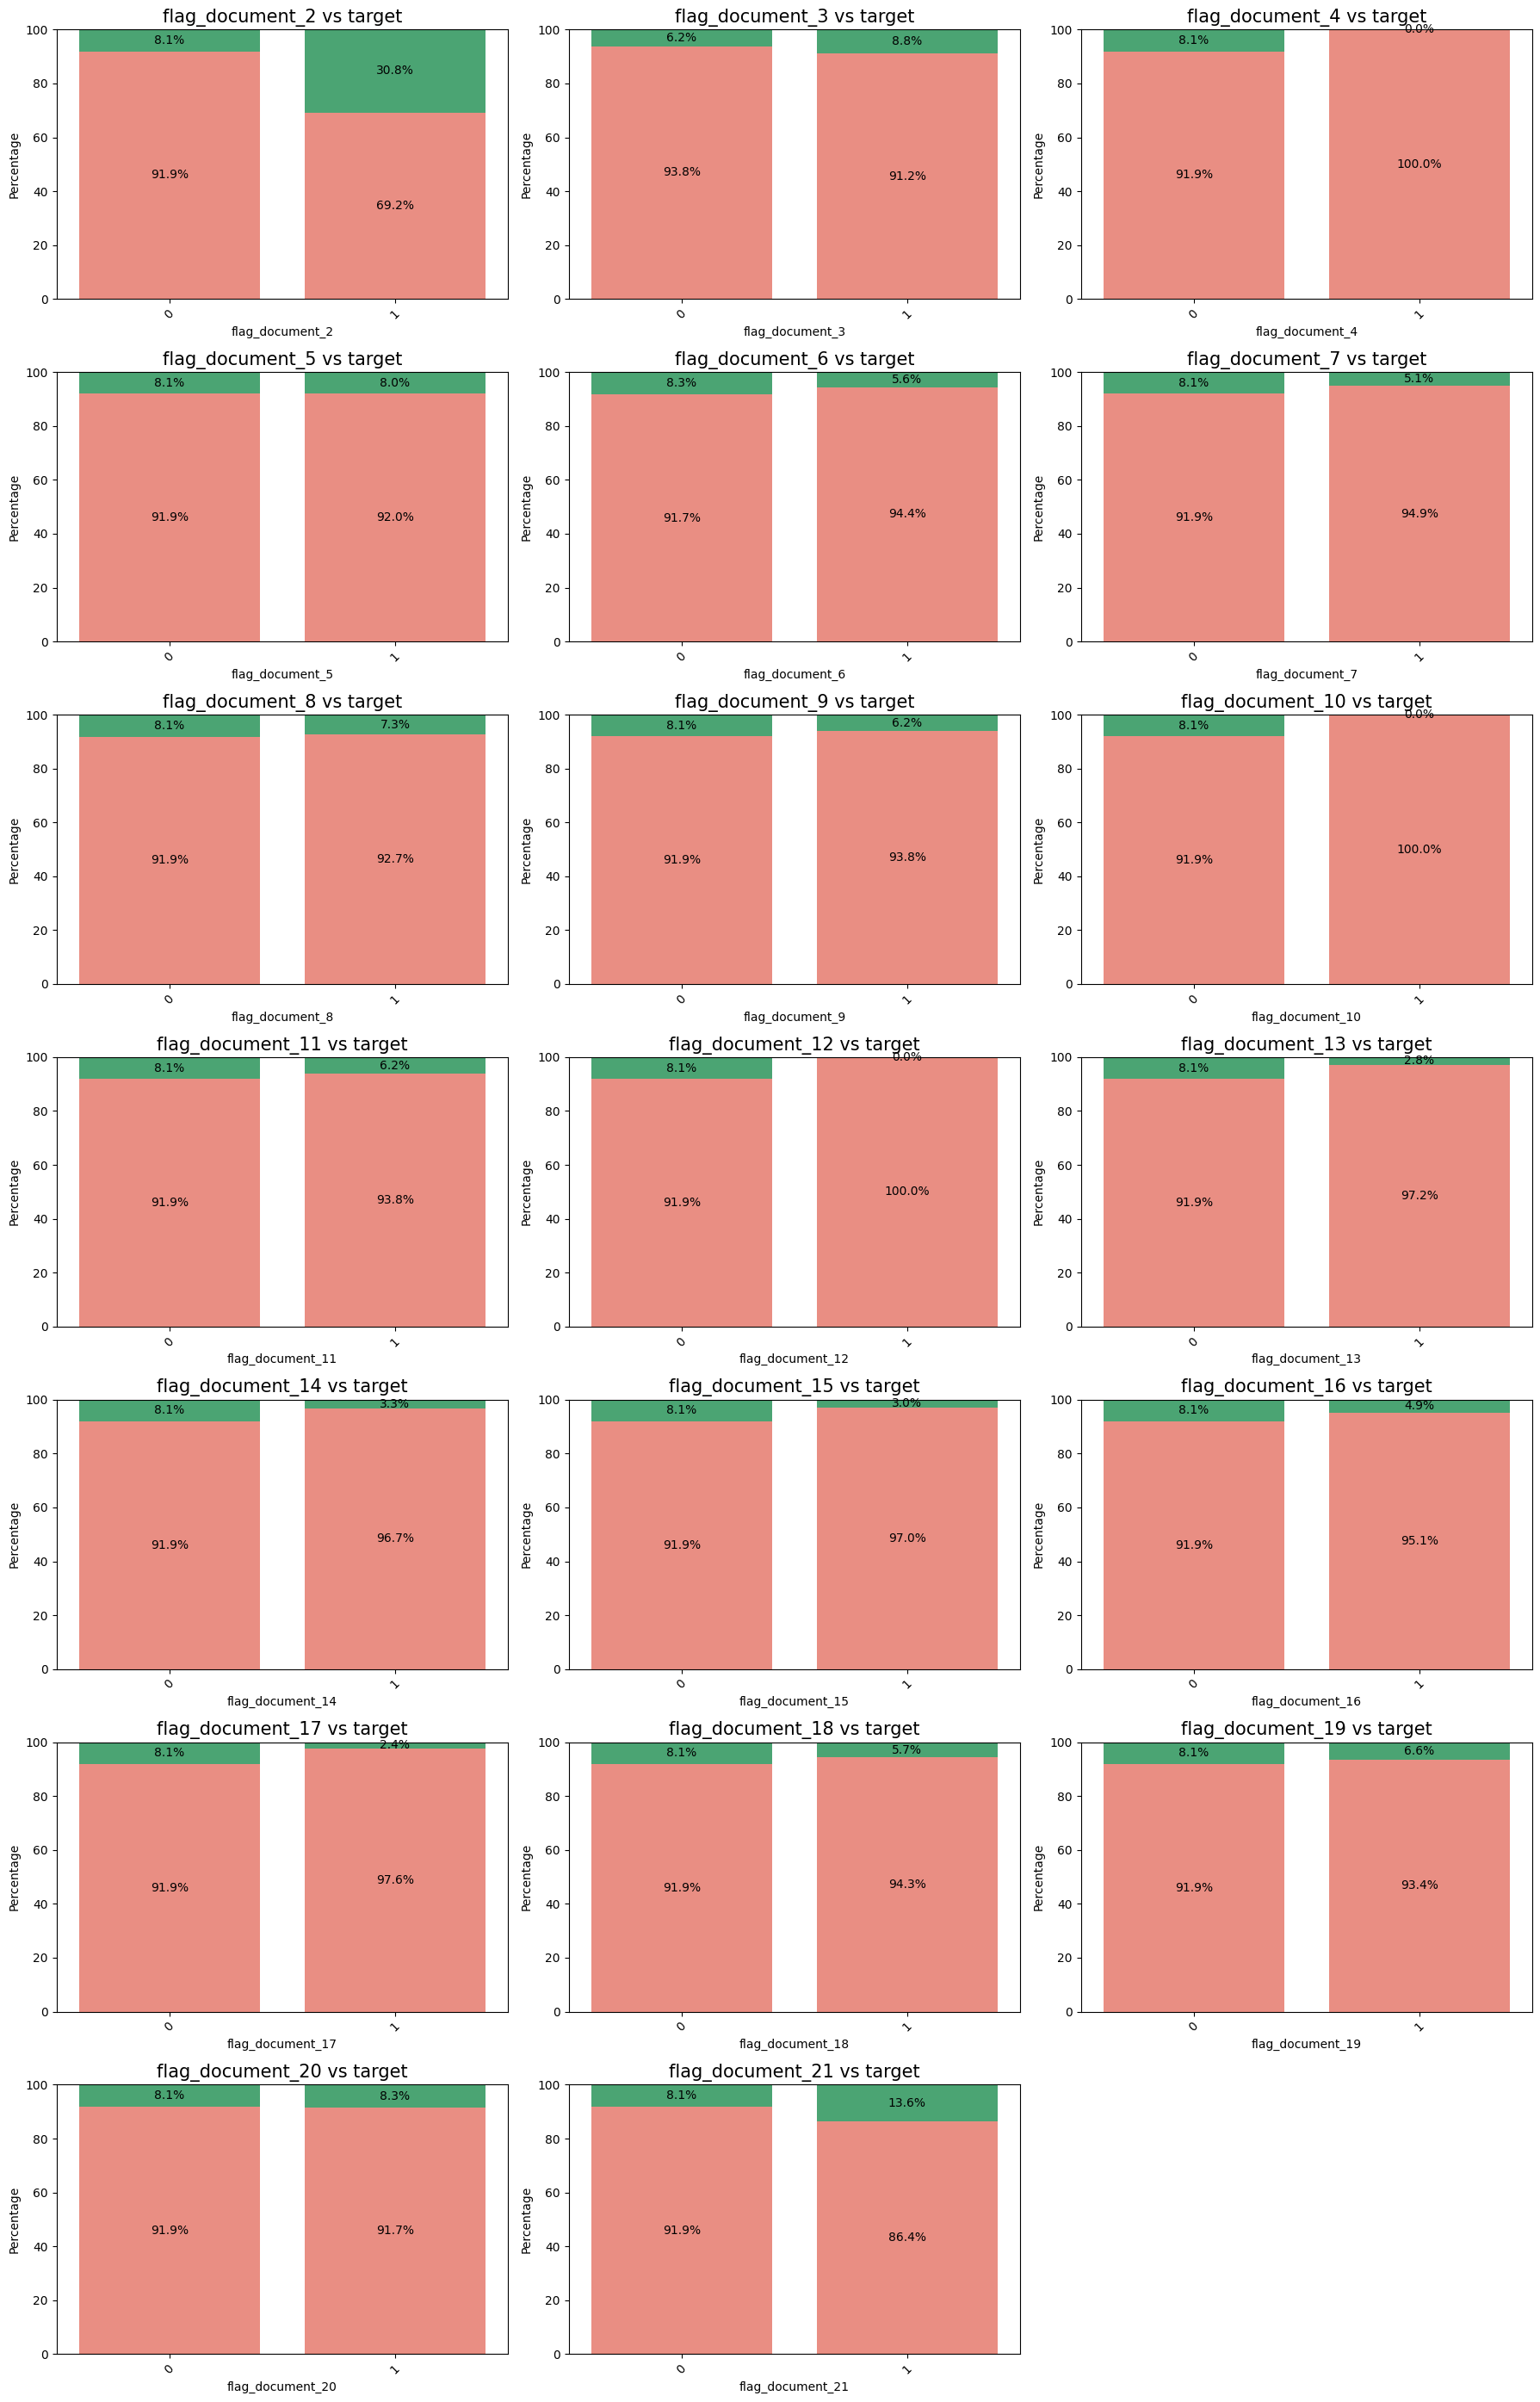

In [20]:
plot_numeric_few_values_features(application_train_df, numeric_few_part_3)

* flag_document_3: The presence of this document is associated with a substantially higher proportion of individuals in the green target group (28.8% when present vs. 8.1% when absent).
* flag_document_10, flag_document_12: Conversely, when these documents are present, there's a significantly lower (near zero) proportion of individuals in the green target group compared to when they are absent.
* flag_document_8, flag_document_15, flag_document_16, flag_document_20: The presence of these documents correlates with a moderately higher proportion of individuals in the green target group (increases of roughly 2.6 to 4.2 percentage points).
* flag_document_2, 4, 7, 9, 13, 14, 17, 18, 19, 21: For this set of documents, their presence is linked to a slight increase in the proportion of individuals in the green target group (increases generally ranging from 1.2 to 2.2 percentage points).
* flag_document_5, flag_document_6, flag_document_11: The presence or absence of these documents shows no meaningful difference or only a very minimal change in the proportion of individuals in the green target group.

#### 3.2.4. Removing Outliers and Seeing Distribution

In [21]:
application_train_df = remove_outliers_by_std(
    application_train_df,
    ["amt_income_total", "obs_30_cnt_social_circle", "obs_60_cnt_social_circle"],
)

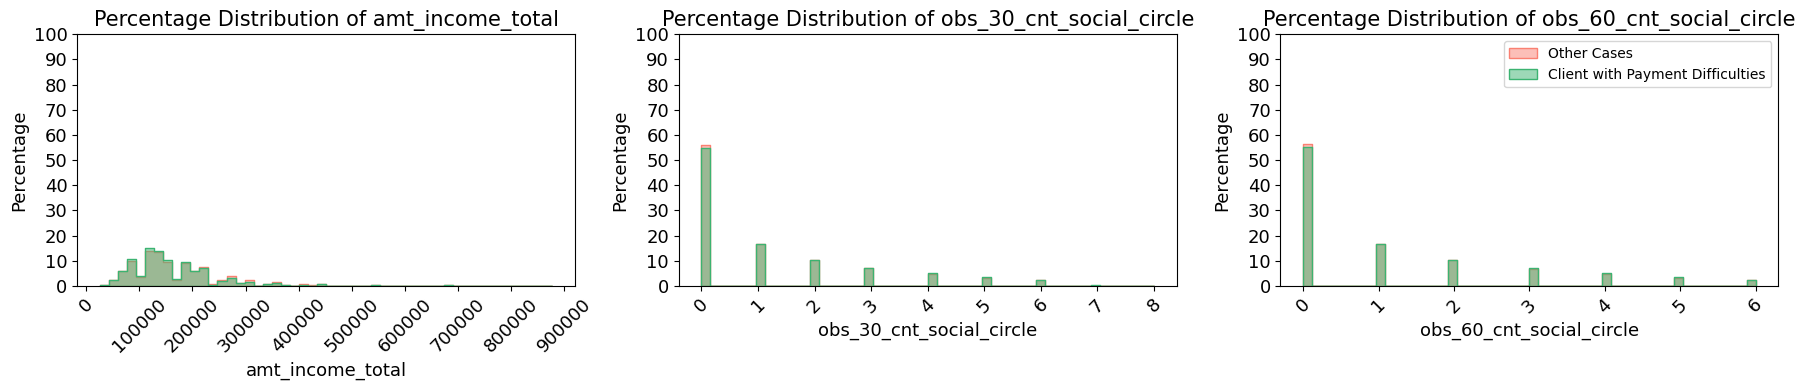

In [22]:
plot_numeric_features(
    application_train_df,
    ["amt_income_total", "obs_30_cnt_social_circle", "obs_60_cnt_social_circle"],
)

#### 3.2.5. Converting Days to Years or Months

In [23]:
application_train_df = convert_days_to_years(application_train_df, ["days_birth"])
application_train_df = convert_days_to_months(
    application_train_df,
    ["days_employed", "days_id_publish", "days_registration", "days_last_phone_change"],
)

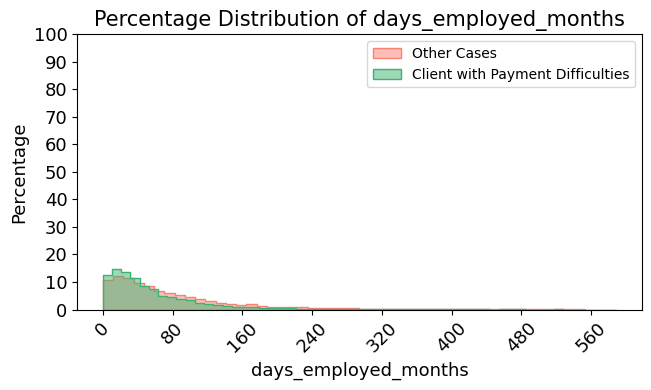

In [24]:
plot_numeric_features(
    application_train_df[application_train_df["days_employed"] != 365243],
    ["days_employed_months"],
)

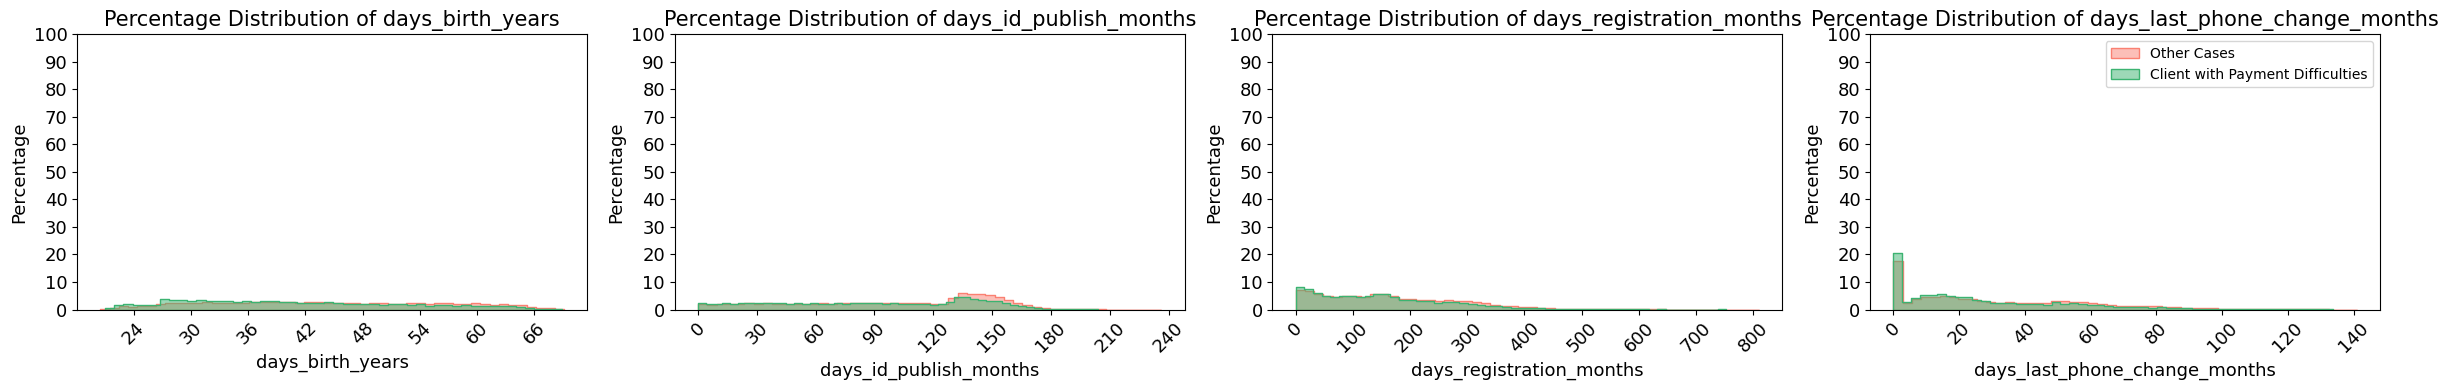

In [25]:
plot_numeric_features(
    application_train_df,
    [
        "days_birth_years",
        "days_id_publish_months",
        "days_registration_months",
        "days_last_phone_change_months",
    ],
)

#### 3.2.6. Correlation

In [26]:
phik_correlations_with_pval(application_train_df, numeric_part_1)

,Correlation,P-Value
days_birth,0.1026,0.0
days_last_phone_change,0.0730,0.0
days_employed,0.0702,0.0
days_id_publish,0.0679,0.0
amt_goods_price,0.0599,0.0
amt_credit,0.0578,0.0
days_registration,0.0541,0.0
region_population_relative,0.0421,0.0
hour_appr_process_start,0.0345,0.0
amt_income_total,0.0333,0.0


These features, suggest to have the most influence:
* days_birth (0.1026),
* days_last_phone_change (0.0730),
* days_employed (0.0702).

These features show minimal association with the target:
* cnt_children (0.0129),
* cnt_fam_members (0.0158).

In [27]:
phik_correlations_with_pval(application_train_df, numeric_part_2)

,Correlation,P-Value
ext_source_3,0.2158,0.0000
ext_source_2,0.2152,0.0000
ext_source_1,0.1397,0.0000
days_last_phone_change,0.0730,0.0000
totalarea_mode,0.0473,0.0000
basementarea_avg,0.0348,0.0000
basementarea_medi,0.0339,0.0000
basementarea_mode,0.0324,0.0000
landarea_avg,0.0261,0.0000
landarea_mode,0.0246,0.0000


These features — they likely capture composite risk indicators and are strong predictive candidates:
* ext_source_3 (0.2158),
* ext_source_2 (0.2152),
* ext_source_1 (0.1397).

Moderately associated features:
* days_last_phone_change (0.0730),
* totalarea_mode (0.0473).

Least associated features:
* obs_60_cnt_social_circle (0.0081),
* obs_30_cnt_social_circle (0.0100).

In [28]:
phik_correlations_with_pval(application_train_df, numeric_part_3)

,Correlation,P-Value
elevators_avg,0.0478,0.0
livingarea_avg,0.0476,0.0
livingarea_medi,0.0475,0.0
apartments_avg,0.0463,0.0
apartments_medi,0.0459,0.0
elevators_mode,0.0453,0.0
apartments_mode,0.0446,0.0
livingarea_mode,0.0444,0.0
landarea_medi,0.0267,0.0
nonlivingarea_medi,0.0193,0.0


Top associated features:
* elevators_avg	(0.0478),
* livingarea_avg (0.0476),
* livingarea_medi (0.0475).

Least associated features:
* nonlivingarea_mode and nonlivingarea_avg (0.0190),
* nonlivingarea_medi (0.0193).

In [29]:
phik_correlations_with_pval(application_train_df, numeric_part_4)

,Correlation,P-Value
floorsmax_avg,0.0554,0.0000
floorsmax_medi,0.0551,0.0000
floorsmax_mode,0.0537,0.0000
elevators_medi,0.0472,0.0000
entrances_mode,0.0346,0.0000
entrances_avg,0.0343,0.0000
entrances_medi,0.0343,0.0000
amt_req_credit_bureau_mon,0.0166,0.0000
amt_req_credit_bureau_year,0.0110,0.0019
years_beginexpluatation_avg,0.0000,0.6672


Top associated features:
* floorsmax_avg (0.0554),
* floorsmax_medi (0.0551),
* floorsmax_mode (0.0537).

No association:
* years_beginexpluatation_avg, years_beginexpluatation_mode, years_beginexpluatation_medi (p > 0.05).

In [30]:
phik_correlations_with_pval(application_train_df, numeric_few_part_1)

,Correlation,P-Value
flag_emp_phone,0.0702,0.0000
flag_work_phone,0.0454,0.0000
flag_phone,0.0368,0.0000
def_30_cnt_social_circle,0.0299,0.0000
def_60_cnt_social_circle,0.0289,0.0000
amt_req_credit_bureau_day,0.0017,0.4272
flag_mobil,0.0000,0.0000
flag_cont_mobile,0.0000,0.3660
flag_email,0.0000,0.8082
amt_req_credit_bureau_qrt,0.0000,0.0000


Top associated features:
* flag_emp_phone (0.0702),
* flag_work_phone (0.0454),
* flag_phone (0.0368).

No association:
* amt_req_credit_bureau_hour and amt_req_credit_bureau_week (p > 0.05).

In [31]:
phik_correlations_with_pval(application_train_df, numeric_few_part_2)

,Correlation,P-Value
reg_city_not_work_city,0.0807,0.0000
reg_city_not_live_city,0.0706,0.0000
live_city_not_work_city,0.0511,0.0000
region_rating_client_w_city,0.0365,0.0000
region_rating_client,0.0351,0.0000
reg_region_not_work_region,0.0106,0.0003
reg_region_not_live_region,0.0086,0.0044
live_region_not_work_region,0.0031,0.2794


Top associated features:
* reg_city_not_work_city (0.0807),
* reg_city_not_live_city (0.0706),
* live_city_not_work_city (0.0511).

No association:
* live_region_not_work_region (p > 0.05).

In [32]:
phik_correlations_with_pval(application_train_df, numeric_few_part_3)

,Correlation,P-Value
flag_document_3,0.0693,0.0000
flag_document_6,0.0439,0.0000
flag_document_13,0.0186,0.0000
flag_document_16,0.0184,0.0000
flag_document_14,0.0137,0.0000
flag_document_8,0.0131,0.0000
flag_document_18,0.0119,0.0000
flag_document_15,0.0092,0.0003
flag_document_2,0.0072,0.0117
flag_document_9,0.0067,0.0172


Top associated features:
* flag_document_3 (0.0693),
* flag_document_6 (0.0439),
* flag_document_13 (0.0186).

No association or negligible:
* flag_document_2, flag_document_9, flag_document_11, flag_document_17 (correlations under 0.01; minimal predictive power despite significance).
* flag_document_21, flag_document_4, flag_document_5, flag_document_7, flag_document_10, flag_document_12, flag_document_19, flag_document_20 - these provide no measurable association with the target variable.


Highest correlations:
* ext_source_3 (0.2158)
* ext_source_2 (0.2152)
* ext_source_1 (0.1397)
* days_birth (0.1026)
* days_last_phone_change (0.0730)
* days_employed (0.0702)
* flag_emp_phone (0.0702)
* days_id_publish (0.0679)
* amt_goods_price (0.0599)
* amt_credit (0.0578)

### 3.3. Categorical Features

In [33]:
application_categorical_features = application_train_df.select_dtypes(
    include=["object", "category"]
).columns

#### 3.3.1. Distribution

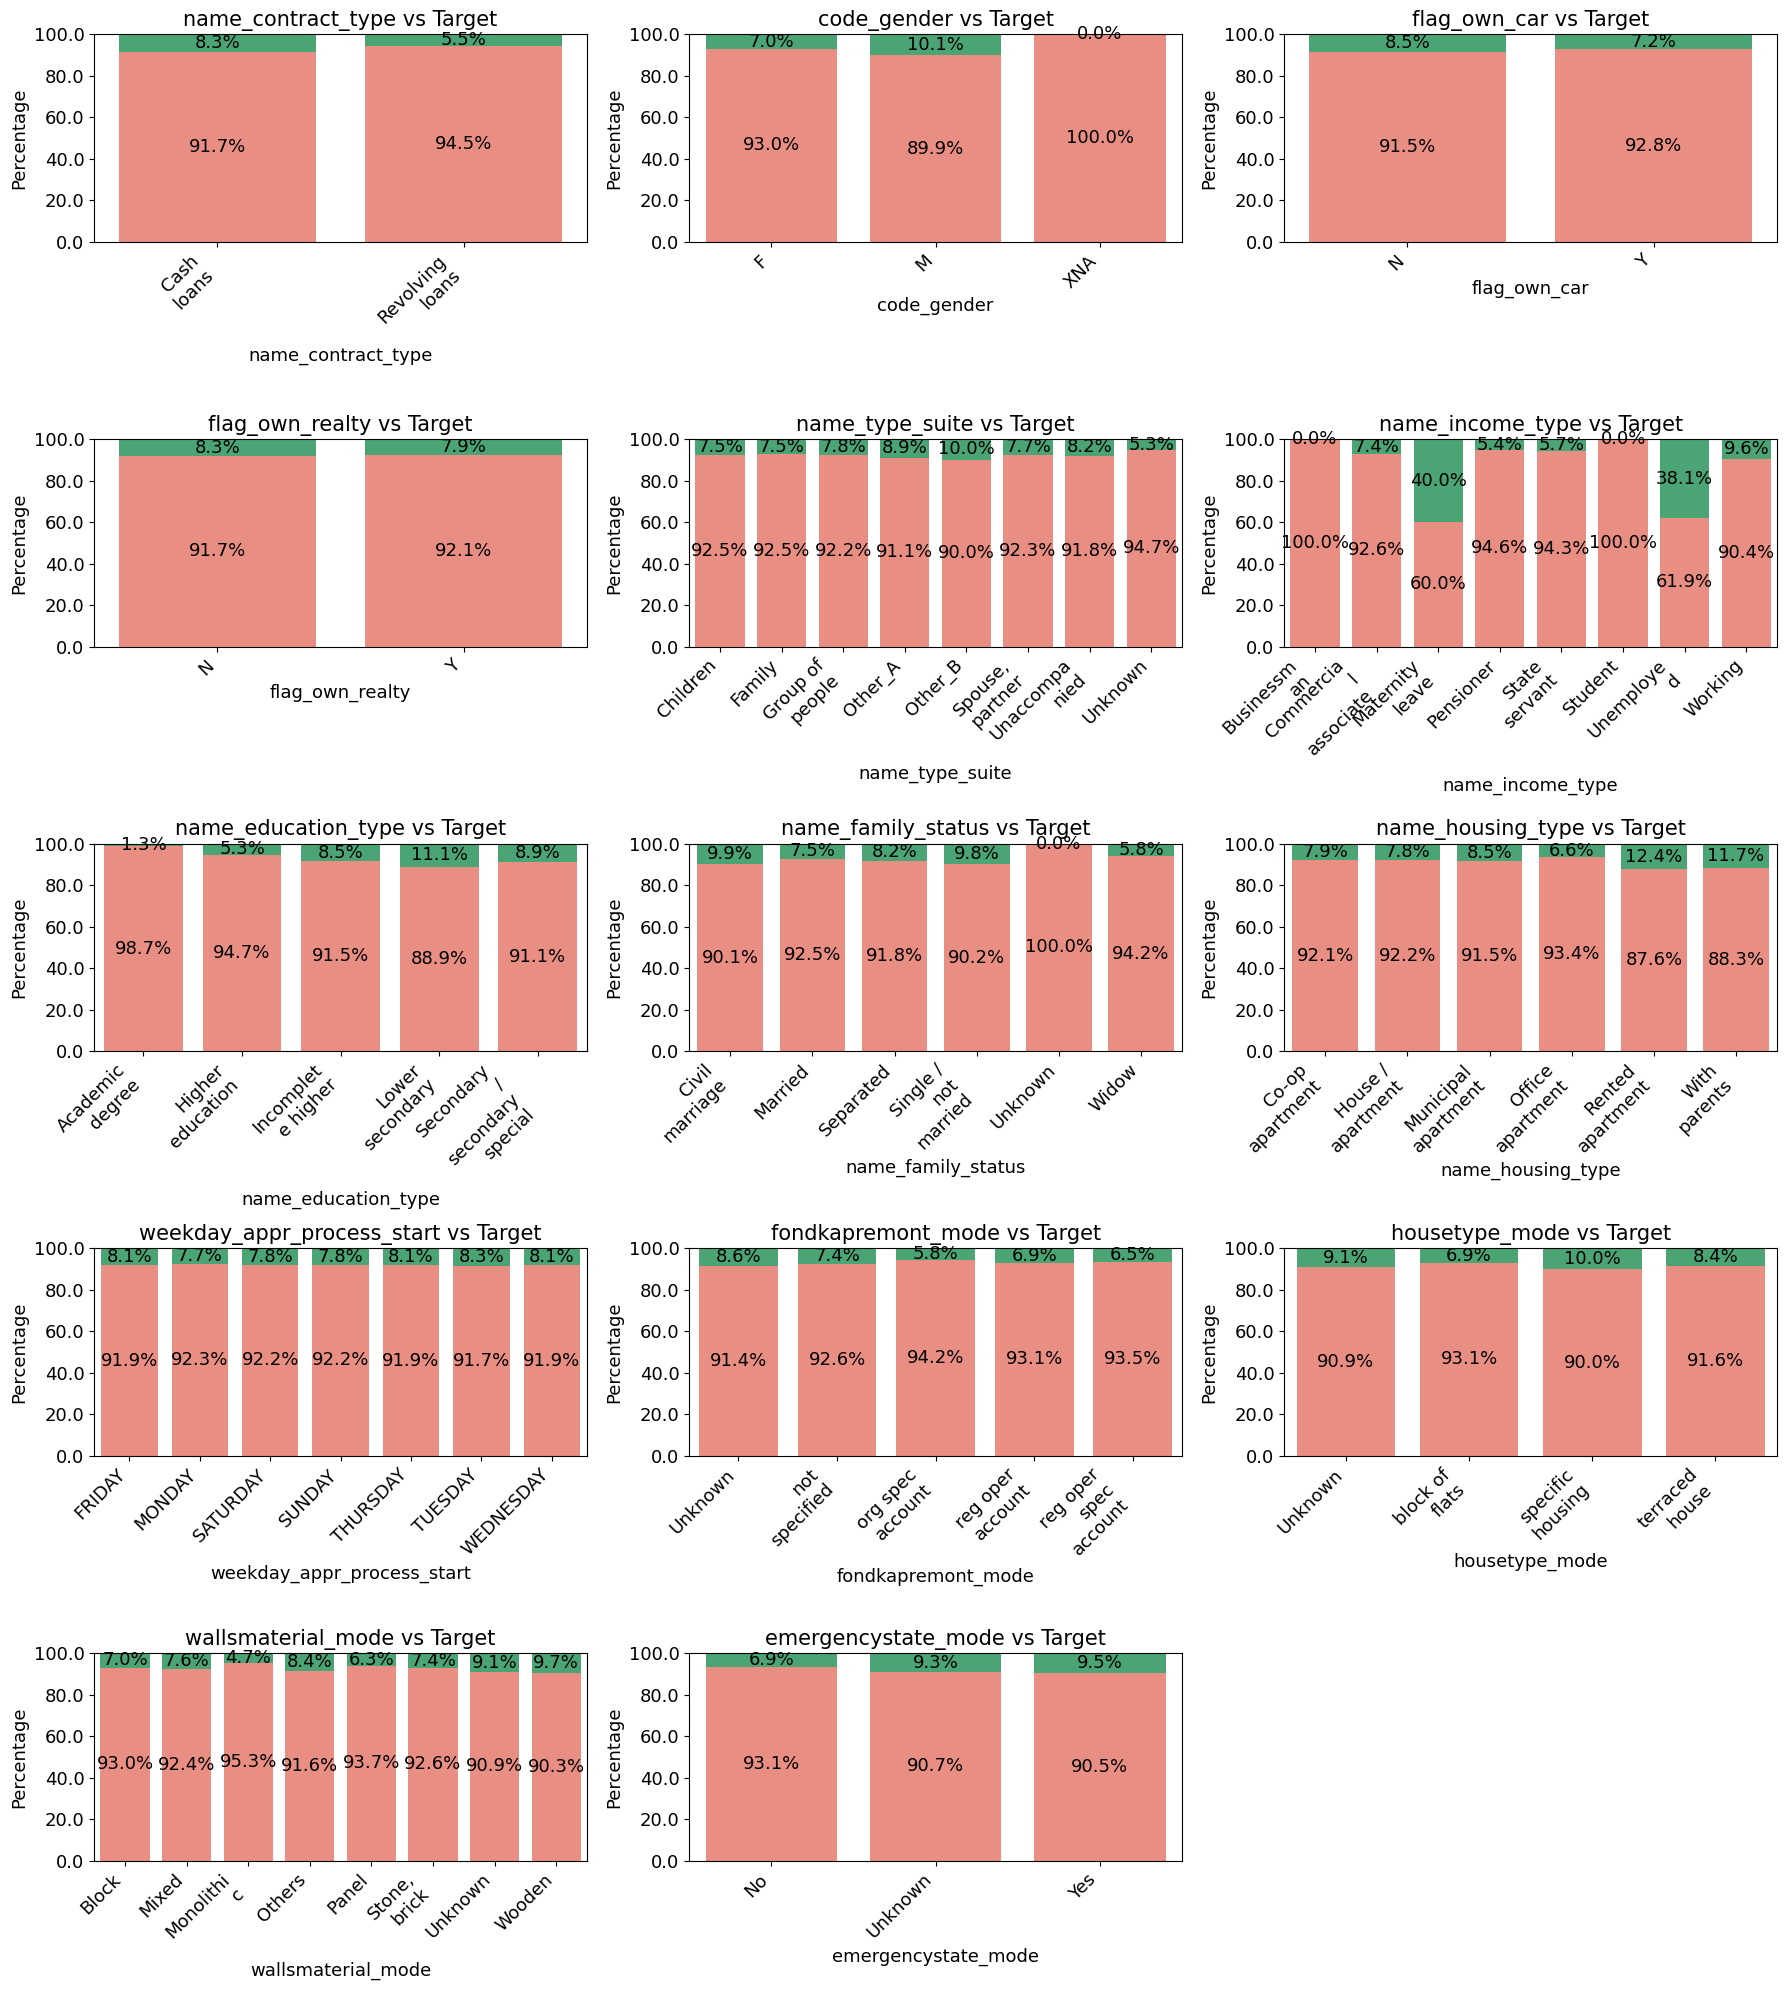

In [34]:
plot_categorical_features(
    application_train_df,
    [
        col
        for col in application_categorical_features
        if col not in {"occupation_type", "organization_type"}
    ],
)

* Clients with cash loans have a slightly higher percentage of payment difficulties.
* Males in this dataset show a higher rate of payment difficulties compared to females.
* Those who do not own a car have a slightly higher percentage of payment difficulties.
* A very small difference, with those not owning realty showing a slightly higher rate of difficulties.
* "Other_B" has the highest rate of payment difficulties, while applicants accompanied by "Children" or "Family" have the lowest among the more common categories.
* Clients on maternity leave and "Unemployed" have a substantially higher rate of payment difficulties. Businessman commeracial and student have no payment difficulties.
* Higher levels of education are associated with lower percentages of payment difficulties.
* Widows have the lowest rate of payment difficulties, while those in a "Civil marriage" or "Single / not married" have the highest rates among the common statuses.
* Clients in rented or municipal apartments, or living with parents, show higher rates of payment difficulties compared to those owning a house/apartment or living in a co-op.
* The day of the week the application process started does not seem to have a significant impact on payment difficulties, with all days showing rates between 7.8% and 8.2%.

In [35]:
print_value_counts_by_target_pct(application_train_df, ["occupation_type"])


occupation_type value counts by target percentage (sorted by target=1):
target                     0      1
occupation_type                    
Low-skill Laborers     83.00  17.00
Drivers                88.64  11.36
Waiters/barmen staff   88.88  11.12
Security staff         89.28  10.72
Laborers               89.44  10.56
Cooking staff          89.67  10.33
Cleaning staff         90.44   9.56
Sales staff            90.44   9.56
Realty agents          92.09   7.91
Secretaries            92.83   7.17
IT staff               93.37   6.63
Medicine staff         93.41   6.59
Private service staff  93.43   6.57
Unknown                93.47   6.53
Core staff             93.75   6.25
High skill tech staff  93.85   6.15
Managers               93.86   6.14
HR staff               93.97   6.03
Accountants            95.20   4.80


Low-skill laborers, drivers and waiters/barmen staff have most payment difficulties.

In [36]:
print_value_counts_by_target_pct(application_train_df, ["organization_type"])


organization_type value counts by target percentage (sorted by target=1):
target                      0      1
organization_type                   
Transport: type 3       84.10  15.90
Industry: type 8        86.36  13.64
Industry: type 13       87.50  12.50
Construction            88.31  11.69
Restaurant              88.33  11.67
Cleaning                88.40  11.60
Industry: type 1        89.10  10.90
Realtor                 89.32  10.68
Industry: type 3        89.54  10.46
Industry: type 4        89.54  10.46
Trade: type 3           89.63  10.37
Agriculture             89.74  10.26
Self-employed           89.90  10.10
Security                90.08   9.92
Trade: type 7           90.57   9.43
Business Entity Type 3  90.72   9.28
Transport: type 4       90.78   9.22
Mobile                  90.85   9.15
Trade: type 1           91.12   8.88
Industry: type 11       91.15   8.85
Postal                  91.49   8.51
Business Entity Type 2  91.58   8.42
Industry: type 7        91.75   8.25


Transport: type 3, industry type: 13 and industry: type 8 have most payment difficulties.

#### 3.3.2. Correlation

In [37]:
application_train_df = pd.get_dummies(
    application_train_df,
    columns=application_train_df.select_dtypes(include=["object", "category"]).columns,
)
encoded_features = application_train_df.select_dtypes(include=["bool"]).columns

In [38]:
categorical_correlation = phik_correlations_with_pval(application_train_df, encoded_features)
categorical_correlation.head(20)

,Correlation,P-Value
name_income_type_Working,0.0906,0.0
name_education_type_Higher education,0.0888,0.0
code_gender_M,0.0861,0.0
code_gender_F,0.0861,0.0
name_education_type_Secondary / secondary special,0.0779,0.0
name_income_type_Pensioner,0.0706,0.0
organization_type_XNA,0.0702,0.0
emergencystate_mode_No,0.0678,0.0
occupation_type_Laborers,0.0676,0.0
emergencystate_mode_Unknown,0.0665,0.0


Top Influential Features (Phi-k > 0.07):
* name_income_type_Working (0.0906),
* name_education_type_Higher education (0.0888),
* code_gender_M, code_gender_F (0.0861),
* name_education_type_Secondary/secondary special (0.0779),
* name_income_type_Pensioner (0.0706),
* organization_type_XNA	(0.0702),
* emergencystate_mode_No (0.0678).

Negligible or Zero Correlation (Phi-k = 0.0000) (Despite some p-values being significant):
* Many organization types (e.g., Legal Services, Mobile, Housing, Telecom, Religion),
* Edge cases in name_type_suite, occupation_type, and weekday_appr_process_start,
* One-hot anomalies like code_gender_XNA, name_family_status_Unknown.


## 4. Statistical Inference

Target population: All individuals applying for credit in the dataset

We have two groups:
1. Client that have payment difficulties
2. Clients that are other cases

In [39]:
payment_difficulties = application_train_df[application_train_df["target"] == 1]
other_cases = application_train_df[application_train_df["target"] == 0]

Does a client's ext_source_3 score differ between those who have payment difficulties and those who don’t?

Hypothesis:
* Null Hypothesis (H₀): The population variances for the two groups are equal.
* Alternative Hypothesis (H₁): The population variances for the two groups are not equal.

This will help to decided which t-test to use:
* if p > 0.05 we use Student’s t-test,
* if p ≤ 0.05 we use Welch’s t-test.

In [40]:
stat, p = stats.levene(
    payment_difficulties["ext_source_3"], other_cases["ext_source_3"]
)
print(f"Levene's Test for {"ext_source_3"}:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")

if p > 0.05:
    print(f"p > 0.05, so we fail to reject H0, variances are equal.")
else:
    print(f"p ≤ 0.05, so we reject H0, variances are not equal.")

Levene's Test for ext_source_3:
Statistic = 1654.6046, p-value = 0.0000
p ≤ 0.05, so we reject H0, variances are not equal.


We reject null hypothesis and Levene's test show that variances are not equal, so we will use Welch's t-test for our analysis.

#### Welch’s t-test is a modified version of the independent t-test that does not assume equal variances.

Hypothesis:
* Null Hypothesis (H0): There is no significant difference between the means of the two groups.
* Alternative Hypothesis (H1): There is a significant difference between the means of the two groups.

In [41]:
stat, p = stats.ttest_ind(
    payment_difficulties["ext_source_3"], other_cases["ext_source_3"], equal_var=False
)
print(f"Welch's t-test for {"ext_source_3"}:")
print(f"Statistic = {stat:.4f}, p-value = {p:.4f}")
if p > 0.05:
    print(
        f"p > 0.05 we fail to reject H0 there is no significant difference between groups."
    )
else:
    print(f"p ≤ 0.05 we reject H0 there is significant difference between groups.")

Welch's t-test for ext_source_3:
Statistic = -77.6175, p-value = 0.0000
p ≤ 0.05 we reject H0 there is significant difference between groups.


We reject null hypothesis, which means there is a statistically significant difference between the two groups.

#### Confidence Interval

In [42]:
def confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std_err = stats.sem(data)
    margin = std_err * stats.t.ppf((1 + confidence) / 2.0, len(data) - 1)
    return round(float(mean - margin), 2), round(float(mean + margin), 2)


ci_1 = confidence_interval(payment_difficulties["ext_source_3"])
ci_0 = confidence_interval(other_cases["ext_source_3"])

print(f"95% Confidence Interval for {"ext_source_3"}:")
print(f"Payment Difficulties: {ci_1}")
print(f"Other Cases: {ci_0}")

95% Confidence Interval for ext_source_3:
Payment Difficulties: (0.42, 0.43)
Other Cases: (0.52, 0.52)


Since none of the confidence intervals overlap, we can say that there are significant differences between the two groups for this feature.